# Performance Evaluation

In [491]:
import json
import torch
import numpy as np
import sys
import os

from tqdm import tqdm

from rdkit import Chem, RDLogger

# Shut up RDKit
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw

import random

import importlib

sys.path.append('./LSTM_TF/')
sys.path.append('./VANILLA_VAE/')

# from sd_lstm_utils import load_model as load_sd_lstm_model

from benchmark_vanilla_vae import VanillaVAEHarness

print('Change me back!')
# from model_vanilla_vae import VanillaMolVAE
from model_vanilla_vae_short import VanillaMolVAE


from rnn_utils import load_model

from fast_rnn_sampler import FastSampler
# from rnn_sampler import ConditionalSmilesRnnSampler
from rnn_utils import load_rnn_model


sys.path.append('utils/')

from smiles_char_dict import SmilesCharDictionary
sd = SmilesCharDictionary()

from evaluation_utils import absolute_metrics, amina_metrics, property_metrics, props_from_smiles, plot_smiles, benchmark_reconstruction_QM9

sys.path.append('../utils/')
from property_calculator import PropertyCalculator

pc = PropertyCalculator(['LogP'])


def smiles_to_tokens(test_smiles, max_seq_len):
    tokens = torch.zeros([len(test_smiles), max_seq_len], dtype=torch.long)
    
    for i in range(len(test_smiles)):
        smi = sd.encode(test_smiles[i])
        tokens[i][0] = sd.char_idx[sd.BEGIN]

        for j in range(len(smi)):
            tokens[i][j+1] = sd.char_idx[smi[j]]
            
        tokens[i][len(smi)+1] = sd.char_idx[sd.END]

    return tokens

Change me back!


# Load Models

In [626]:
# model_definit  = 'models/NEW_LONG_RUNS/QM9/cVAE/SD_LSTM_odd-wind-32_Epoch_310_Vl_0.114.json'
# model_weights  = 'models/NEW_LONG_RUNS/QM9/cVAE/SD_LSTM_odd-wind-32_Epoch_310_Vl_0.114.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE/SD_REG_VANILLA_VAE_dawn-band-89_Epoch_294_Vl_0.086.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE/SD_REG_VANILLA_VAE_dawn-band-89_Epoch_294_Vl_0.086.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE-KLD/SD_REG_VANILLA_VAE_ancient-paper-11_Epoch_235_Vl_0.353.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE-KLD/SD_REG_VANILLA_VAE_ancient-paper-11_Epoch_235_Vl_0.353.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol/SD_REG_VANILLA_VAE_still-field-09_Epoch_330_Vl_0.095.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol/SD_REG_VANILLA_VAE_still-field-09_Epoch_330_Vl_0.095.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol2/SD_REG_VANILLA_VAE_still-rain-34_Epoch_313_Vl_0.349.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol2/SD_REG_VANILLA_VAE_still-rain-34_Epoch_313_Vl_0.349.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol2/SD_REG_VANILLA_VAE_still-rain-34_Epoch_313_Vl_0.349.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol2/SD_REG_VANILLA_VAE_still-rain-34_Epoch_313_Vl_0.349.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE-KLD-Mean16/SD_REG_VANILLA_VAE_fragrant-fog-89_Epoch_99_Vl_0.064.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE-KLD-Mean16/SD_REG_VANILLA_VAE_fragrant-fog-89_Epoch_99_Vl_0.064.pt'

### ------ SMALL LATENT ---- 

# model_definit = 'models/NARROW_SAMPLING_LONG_RUNS/QM9/cVAE/SD_REG_VANILLA_VAE_dawn-band-89_Epoch_294_Vl_0.086.json'
# model_weights = 'models/NARROW_SAMPLING_LONG_RUNS/QM9/cVAE/SD_REG_VANILLA_VAE_dawn-band-89_Epoch_294_Vl_0.086.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE-KLD/SD_REG_VANILLA_VAE_little-hat-65_Epoch_208_Vl_0.067.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE-KLD/SD_REG_VANILLA_VAE_little-hat-65_Epoch_208_Vl_0.067.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol/SD_REG_VANILLA_VAE_floral-sun-71_Epoch_316_Vl_0.077.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol/SD_REG_VANILLA_VAE_floral-sun-71_Epoch_316_Vl_0.077.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol2/SD_REG_VANILLA_VAE_blue-silence-20_Epoch_270_Vl_0.351.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol2/SD_REG_VANILLA_VAE_blue-silence-20_Epoch_270_Vl_0.351.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE-KLD/SD_REG_VANILLA_VAE_little-hat-65_Epoch_208_Vl_0.067.json'
# model_weights = 'models/NEW_0.9930LONG_RUNS/QM9/cVAE-KLD/SD_REG_VANILLA_VAE_little-hat-65_Epoch_208_Vl_0.067.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol/SD_REG_VANILLA_VAE_floral-sun-71_Epoch_316_Vl_0.077.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol/SD_REG_VANILLA_VAE_floral-sun-71_Epoch_316_Vl_0.077.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/BATCH_POSTERIOR_REGULARIZERS/cVAE-KLD/SD_REG_VANILLA_VAE_jolly-cloud-51_Epoch_271_Vl_0.119.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/BATCH_POSTERIOR_REGULARIZERS/cVAE-KLD/SD_REG_VANILLA_VAE_jolly-cloud-51_Epoch_271_Vl_0.119.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/BATCH_POSTERIOR_REGULARIZERS/cVAE-Pol/SD_REG_VANILLA_VAE_solitary-dew-01_Epoch_379_Vl_0.141.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/BATCH_POSTERIOR_REGULARIZERS/cVAE-Pol/SD_REG_VANILLA_VAE_solitary-dew-01_Epoch_379_Vl_0.141.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/BATCH_POSTERIOR_REGULARIZERS/cVAE-Pol2/SD_REG_VANILLA_VAE_orange-math-80_Epoch_498_Vl_0.657.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/BATCH_POSTERIOR_REGULARIZERS/cVAE-Pol2/SD_REG_VANILLA_VAE_orange-math-80_Epoch_498_Vl_0.657.pt'

### EXPERIMENTS ###

# model_definit = 'models/EXPERIMENTS/INV-BETA-EPS-36/SD_REG_VANILLA_VAE_curly-snowflake-70_Epoch_132_Vl_0.344.json'
# model_weights = 'models/EXPERIMENTS/INV-BETA-EPS-36/SD_REG_VANILLA_VAE_curly-snowflake-70_Epoch_132_Vl_0.344.pt'

# model_definit = 'models/EXPERIMENTS/BETA01-EPS10-36/SD_REG_VANILLA_VAE_solitary-recipe-47_Epoch_498_Vl_1.543.json'
# model_weights = 'models/EXPERIMENTS/BETA01-EPS10-36/SD_REG_VANILLA_VAE_solitary-recipe-47_Epoch_498_Vl_1.543.pt'

# model_definit = 'models/EXPERIMENTS/BETA0001-EPS10-36/SD_REG_VANILLA_VAE_hidden-sound-08_Epoch_198_Vl_0.046.json'
# model_weights = 'models/EXPERIMENTS/BETA0001-EPS10-36/SD_REG_VANILLA_VAE_hidden-sound-08_Epoch_198_Vl_0.046.pt'

# model_definit = 'models/EXPERIMENTS/BETA001-EPS001-36/SD_REG_VANILLA_VAE_morning-queen-60_Epoch_186_Vl_0.013.json'
# model_weights = 'models/EXPERIMENTS/BETA001-EPS001-36/SD_REG_VANILLA_VAE_morning-queen-60_Epoch_186_Vl_0.013.pt'

# model_definit = 'models/EXPERIMENTS/BETA001-EPS01/SD_REG_VANILLA_VAE_noisy-union-55_Epoch_306_Vl_0.029.json'
# model_weights = 'models/EXPERIMENTS/BETA001-EPS01/SD_REG_VANILLA_VAE_noisy-union-55_Epoch_306_Vl_0.029.pt'

# model_definit = 'models/EXPERIMENTS/BETA0005-EPS10/SD_REG_VANILLA_VAE_soft-field-60_Epoch_166_Vl_0.163.json'
# model_weights = 'models/EXPERIMENTS/BETA0005-EPS10/SD_REG_VANILLA_VAE_soft-field-60_Epoch_166_Vl_0.163.pt'

# model_definit = 'models/EXPERIMENTS/BETA001-EPS10-LS106/SD_REG_VANILLA_VAE_broken-shadow-50_Epoch_156_Vl_0.392.json'
# model_weights = 'models/EXPERIMENTS/BETA001-EPS10-LS106/SD_REG_VANILLA_VAE_broken-shadow-50_Epoch_156_Vl_0.392.pt'

# model_definit = 'models/EXPERIMENTS/ANNEALING_1/SD_REG_VANILLA_VAE_orange-paper-61_Epoch_166_Vl_0.315.json'
# model_weights = 'models/EXPERIMENTS/ANNEALING_1/SD_REG_VANILLA_VAE_orange-paper-61_Epoch_166_Vl_0.315.pt'

# model_definit = 'models/EXPERIMENTS/BETA001-EPS10-LS32/SD_REG_VANILLA_VAE_withered-thunder-36_Epoch_111_Vl_0.340.json'
# model_weights = 'models/EXPERIMENTS/BETA001-EPS10-LS32/SD_REG_VANILLA_VAE_withered-thunder-36_Epoch_111_Vl_0.340.pt'

# model_definit = 'models/EXPERIMENTS/BETA001-EPS10/SD_REG_VANILLA_VAE_nameless-fog-81_Epoch_150_Vl_0.335.json'
# model_weights = 'models/EXPERIMENTS/BETA001-EPS10/SD_REG_VANILLA_VAE_nameless-fog-81_Epoch_150_Vl_0.335.pt'

### ZINC ###

# model_definit = 'models/FIXED_LONG_RUNS/ZINC/cVAE/SD_REG_VANILLA_VAE_fancy-pine-10_Epoch_108_Vl_0.745.json'
# model_weights = 'models/FIXED_LONG_RUNS/ZINC/cVAE/SD_REG_VANILLA_VAE_fancy-pine-10_Epoch_108_Vl_0.745.pt'

### FQM9 ###

# model_definit = 'models/FIXED_LONG_RUNS/QM9/cVAE-Pol/SD_REG_VANILLA_VAE_calm-bird-16_Epoch_180_Vl_1.538.json'
# model_weights = 'models/FIXED_LONG_RUNS/QM9/cVAE-Pol/SD_REG_VANILLA_VAE_calm-bird-16_Epoch_180_Vl_1.538.pt'

# model_definit = 'models/FIXED_LONG_RUNS/QM9/cVAE-Pol-Post/SD_REG_VANILLA_VAE_winter-feather-99_Epoch_144_Vl_0.479.json'
# model_weights = 'models/FIXED_LONG_RUNS/QM9/cVAE-Pol-Post/SD_REG_VANILLA_VAE_winter-feather-99_Epoch_144_Vl_0.479.pt'

# model_definit = 'models/FIXED_LONG_RUNS/QM9/cVAE-Pol2-Post2/SD_REG_VANILLA_VAE_calm-term-70_Epoch_180_Vl_0.917.json'
# model_weights = 'models/FIXED_LONG_RUNS/QM9/cVAE-Pol2-Post2/SD_REG_VANILLA_VAE_calm-term-70_Epoch_180_Vl_0.917.pt'

# model_definit = 'models/EXPERIMENTS/Pol2-rewrite/SD_REG_VANILLA_VAE_black-art-85_Epoch_90_Vl_0.537.json'
# model_weights = 'models/EXPERIMENTS/Pol2-rewrite/SD_REG_VANILLA_VAE_black-art-85_Epoch_90_Vl_0.537.pt'

# model_definit = 'models/EXPERIMENTS/Pol2-rewrite/SD_REG_VANILLA_VAE_black-art-85_Epoch_126_Vl_0.530.json'
# model_weights = 'models/EXPERIMENTS/Pol2-rewrite/SD_REG_VANILLA_VAE_black-art-85_Epoch_126_Vl_0.530.pt'

# model_definit = 'models/EXPERIMENTS/LARGE_SAMPLING_Pol2/SD_REG_VANILLA_VAE_dawn-shape-00_Epoch_108_Vl_0.534.json'
# model_weights = 'models/EXPERIMENTS/LARGE_SAMPLING_Pol2/SD_REG_VANILLA_VAE_dawn-shape-00_Epoch_108_Vl_0.534.pt'

# model_definit = written'models/EXPERIMENTS/LINEAR_POSITIVE_ANNEALING_Pol2/SD_REG_VANILLA_VAE_cool-glade-18_Epoch_138_Vl_0.541.json'
# model_weights = 'models/EXPERIMENTS/LINEAR_POSITIVE_ANNEALING_Pol2/SD_REG_VANILLA_VAE_cool-glade-18_Epoch_138_Vl_0.541.pt'

# model_definit = 'models/EXPERIMENTS/LINEAR_NEGATIVE_ANNEALING_Pol2/SD_REG_VANILLA_VAE_dry-boat-50_Epoch_151_Vl_0.552.json'
# model_weights = 'models/EXPERIMENTS/LINEAR_NEGATIVE_ANNEALING_Pol2/SD_REG_VANILLA_VAE_dry-boat-50_Epoch_151_Vl_0.552.pt'

# model_definit = 'models/EXPERIMENTS/Pol1-rewrite/SD_REG_VANILLA_VAE_autumn-block-43_Epoch_30_Vl_1.831.json'
# model_weights = 'models/EXPERIMENTS/Pol1-rewrite/SD_REG_VANILLA_VAE_autumn-block-43_Epoch_30_Vl_1.831.pt'

# model_definit = 'models/EXPERIMENTS/cVAE-Pol2-Again/SD_REG_VANILLA_VAE_shiny-frost-20_Epoch_157_Vl_0.512.json'
# model_weights = 'models/EXPERIMENTS/cVAE-Pol2-Again/SD_REG_VANILLA_VAE_shiny-frost-20_Epoch_157_Vl_0.512.pt'

# model_definit = 'models/FIXED_LONG_RUNS/QM9/All-cVAE/cVAE-Pol-Rewrite1/SD_REG_VANILLA_VAE_snowy-sunset-70_Epoch_87_Vl_1.311.json'
# model_weights = 'models/FIXED_LONG_RUNS/QM9/All-cVAE/cVAE-Pol-Rewrite1/SD_REG_VANILLA_VAE_snowy-sunset-70_Epoch_87_Vl_1.311.pt'

# model_definit = 'models/FIXING_POST/cVAE-BETA10-EPS001/SD_REG_VANILLA_VAE_icy-flower-13_Epoch_280_Vl_0.152.json'
# model_weights = 'models/FIXING_POST/cVAE-BETA10-EPS001/SD_REG_VANILLA_VAE_icy-flower-13_Epoch_280_Vl_0.152.pt'

# model_definit = 'models/FIXING_POST/cVAE-BETA50-EPS001/SD_REG_VANILLA_VAE_orange-lab-73_Epoch_257_Vl_0.819.json'
# model_weights = 'models/FIXING_POST/cVAE-BETA50-EPS001/SD_REG_VANILLA_VAE_orange-lab-73_Epoch_257_Vl_0.819.pt'

# model_definit = 'models/FIXING_POST/GB_Params/SD_REG_VANILLA_VAE_wild-rain-13_Epoch_105_Vl_0.010.json'
# model_weights = 'models/FIXING_POST/GB_Params/SD_REG_VANILLA_VAE_wild-rain-13_Epoch_105_Vl_0.010.pt'

# model_definit = 'models/FIXING_POST/GB_Params/SD_REG_VANILLA_VAE_wild-rain-13_Epoch_50_Vl_0.025.json'
# model_weights = 'models/FIXING_POST/GB_Params/SD_REG_VANILLA_VAE_wild-rain-13_Epoch_50_Vl_0.025.pt'

# model_definit = 'models/FIXING_POST/GB_Params/SD_REG_VANILLA_VAE_wild-rain-13_Epoch_75_Vl_0.014.json'
# model_weights = 'models/FIXING_POST/GB_Params/SD_REG_VANILLA_VAE_wild-rain-13_Epoch_75_Vl_0.014.pt'

# model_definit = 'models/FIXING_POST/GB_Params_5x/SD_REG_VANILLA_VAE_wild-flower-23_Epoch_99_Vl_0.009.json'
# model_weights = 'models/FIXING_POST/GB_Params_5x/SD_REG_VANILLA_VAE_wild-flower-23_Epoch_99_Vl_0.009.pt'

# model_definit = 'models/FIXING_POST/GB_Params/SD_REG_VANILLA_VAE_winter-mouse-33_Epoch_122_Vl_0.009.json'
# model_weights = 'models/FIXING_POST/GB_Params/SD_REG_VANILLA_VAE_winter-mouse-33_Epoch_122_Vl_0.009.pt'

# model_definit = 'models/FIXING_POST/GB_Params_01/SD_REG_VANILLA_VAE_hidden-star-63_Epoch_78_Vl_0.008.json'
# model_weights = 'models/FIXING_POST/GB_Params_01/SD_REG_VANILLA_VAE_hidden-star-63_Epoch_78_Vl_0.008.pt'

# model_definit = 'models/FIXING_POST/GB_Params_1L/SD_REG_VANILLA_VAE_ancient-snowflake-67_Epoch_105_Vl_0.008.json'
# model_weights = 'models/FIXING_POST/GB_Params_1L/SD_REG_VANILLA_VAE_ancient-snowflake-67_Epoch_105_Vl_0.008.pt'

# model_definit = 'models/GB_PARAMS/QM9/One-Shot/cVAE/SD_REG_VANILLA_VAE_lively-king-16_Epoch_240_Vl_0.058.json'
# model_weights = 'models/GB_PARAMS/QM9/One-Shot/cVAE/SD_REG_VANILLA_VAE_lively-king-16_Epoch_240_Vl_0.058.pt'

# model_definit = 'models/GB_PARAMS/QM9/One-Shot/cVAE/SD_REG_VANILLA_VAE_lively-king-16_Epoch_150_Vl_0.059.json'
# model_weights = 'models/GB_PARAMS/QM9/One-Shot/cVAE/SD_REG_VANILLA_VAE_lively-king-16_Epoch_150_Vl_0.059.pt'

# model_definit = 'models/GB_PARAMS/QM9/One-Shot/cVAE-KLD/SD_REG_VANILLA_VAE_delicate-sky-60_Epoch_402_Vl_0.123.json'
# model_weights = 'models/GB_PARAMS/QM9/One-Shot/cVAE-KLD/SD_REG_VANILLA_VAE_delicate-sky-60_Epoch_402_Vl_0.123.pt'

# model_definit = 'models/GB_PARAMS/QM9/One-Shot/cVAE-Pol/SD_REG_VANILLA_VAE_red-grass-60_Epoch_228_Vl_0.181.json'
# model_weights = 'models/GB_PARAMS/QM9/One-Shot/cVAE-Pol/SD_REG_VANILLA_VAE_red-grass-60_Epoch_228_Vl_0.181.pt'

# model_definit = 'models/GB_PARAMS/QM9/One-Shot/cVAE-Pol2/SD_REG_VANILLA_VAE_weathered-flower-56_Epoch_220_Vl_1.648.json'
# model_weights = 'models/GB_PARAMS/QM9/One-Shot/cVAE-Pol2/SD_REG_VANILLA_VAE_weathered-flower-56_Epoch_220_Vl_1.648.pt'

# model_definit = 'models/GB_PARAMS/QM9/One-Shot/cVAE-Pol2/SD_REG_VANILLA_VAE_weathered-flower-56_Epoch_220_Vl_1.648.json'
# model_weights = 'models/GB_PARAMS/QM9/One-Shot/cVAE-Pol2/SD_REG_VANILLA_VAE_weathered-flower-56_Epoch_220_Vl_1.648.pt'

# model_definit = 'models/GB_PARAMS/ZINC/One-Shot/cVAE/SD_REG_VANILLA_VAE_black-shadow-04_Epoch_408_Vl_0.250.json'
# model_weights = 'models/GB_PARAMS/ZINC/One-Shot/cVAE/SD_REG_VANILLA_VAE_black-shadow-04_Epoch_408_Vl_0.250.pt'

# model_definit = 'models/GB_PARAMS/ZINC/One-Shot/cVAE-KLD/SD_REG_VANILLA_VAE_red-wave-57_Epoch_397_Vl_0.275.json'
# model_weights = 'models/GB_PARAMS/ZINC/One-Shot/cVAE-KLD/SD_REG_VANILLA_VAE_red-wave-57_Epoch_397_Vl_0.275.pt'

# model_definit = 'models/POL-FIX/MANUAL/SD_REG_VANILLA_VAE_aged-sun-98_Epoch_144_Vl_1.065.json'
# model_weights = 'models/POL-FIX/MANUAL/SD_REG_VANILLA_VAE_aged-sun-98_Epoch_144_Vl_1.065.pt'

# model_definit = 'models/POL-FIX/MODULE_JUST/SD_REG_VANILLA_VAE_white-firefly-13_Epoch_300_Vl_0.246.json'
# model_weights = 'models/POL-FIX/MODULE_JUST/SD_REG_VANILLA_VAE_white-firefly-13_Epoch_300_Vl_0.246.pt'

# model_definit = 'models/GB_PARAMS/QM9/One-Shot/cVAE-Pol/SD_REG_VANILLA_VAE_shy-feather-55_Epoch_46_Vl_1.653.json'
# model_weights = 'models/GB_PARAMS/QM9/One-Shot/cVAE-Pol/SD_REG_VANILLA_VAE_shy-feather-55_Epoch_46_Vl_1.653.pt'

# model_definit = 'models/GB_PARAMS/ZINC/One-Shot/cVAE-Pol/SD_REG_VANILLA_VAE_round-frog-56_Epoch_90_Vl_3.838.json'
# model_weights = 'models/GB_PARAMS/ZINC/One-Shot/cVAE-Pol/SD_REG_VANILLA_VAE_round-frog-56_Epoch_90_Vl_3.838.pt'

# model_definit = 'models/POL-FIX/FIX1/SD_REG_VANILLA_VAE_restless-sea-13_Epoch_120_Vl_1.702.json'
# model_weights = 'models/POL-FIX/FIX1/SD_REG_VANILLA_VAE_restless-sea-13_Epoch_120_Vl_1.702.pt'

# model_definit = 'models/POL-FIX/FIX2/SD_REG_VANILLA_VAE_orange-cherry-66_Epoch_150_Vl_1.651.json'
# model_weights = 'models/POL-FIX/FIX2/SD_REG_VANILLA_VAE_orange-cherry-66_Epoch_150_Vl_1.651.pt'

# model_definit = 'models/GB_POST/One-Shot/cVAE-KLD/SD_REG_VANILLA_VAE_orange-night-07_Epoch_249_Vl_0.243.json'
# model_weights = 'models/GB_POST/One-Shot/cVAE-KLD/SD_REG_VANILLA_VAE_orange-night-07_Epoch_249_Vl_0.243.pt'

# model_definit = 'models/GB_POST/One-Shot/cVAE-Pol/SD_REG_VANILLA_VAE_small-glitter-22_Epoch_51_Vl_2.415.json'
# model_weights = 'models/GB_POST/One-Shot/cVAE-Pol/SD_REG_VANILLA_VAE_small-glitter-22_Epoch_51_Vl_2.415.pt'

# model_definit = 'models/GB_POST/One-Shot/cVAE-Pol2/SD_REG_VANILLA_VAE_orange-butterfly-56_Epoch_151_Vl_2.375.json'
# model_weights = 'models/GB_POST/One-Shot/cVAE-Pol2/SD_REG_VANILLA_VAE_orange-butterfly-56_Epoch_151_Vl_2.375.pt'


cvae_sampler = VanillaVAEHarness(batch_size=64, device='cpu')

cvae_model = load_model(model_class=VanillaMolVAE, model_definition=model_definit, model_weights=model_weights, device='cpu')

# ugly hack
cvae_model = cvae_model.to('cpu')
cvae_model.device = 'cpu'
cvae_model.encoder.device = 'cpu'
cvae_model.state_decoder.device = 'cpu'

a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


RuntimeError: Error(s) in loading state_dict for VanillaMolVAE:
	Missing key(s) in state_dict: "state_decoder.z_to_latent.weight", "state_decoder.z_to_latent.bias". 
	Unexpected key(s) in state_dict: "state_decoder.action_to_latent.weight". 
	size mismatch for state_decoder.gru.weight_ih_l0: copying a param with shape torch.Size([1503, 385]) from checkpoint, the shape in current model is torch.Size([1503, 193]).

In [627]:
# Load Explicit cVAE Model

# TODO: FIX NAME CLASHES
file_path = 'ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py'

# Load the module specified by the file path
spec = importlib.util.spec_from_file_location("model_vanilla_vae.py", file_path)
module = importlib.util.module_from_spec(spec)
sys.modules["model_vanilla_vae"] = module
spec.loader.exec_module(module)

explicit_model_class = module.VanillaMolVAE

file_path = 'ACTION_SAMPLING_VANILLA_VAE/action_sampling_vae_sampler.py'

# Load the module specified by the file path
spec = importlib.util.spec_from_file_location("action_sampling_vae_sampler.py", file_path)
module = importlib.util.module_from_spec(spec)
sys.modules["action_sampling_vae_sampler"] = module
spec.loader.exec_module(module)

harness_class = module.VanillaVAEHarness

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD-TF10/SD_REG_VANILLA_VAE_small-lake-03_Epoch_110_Vl_0.119.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD-TF10/SD_REG_VANILLA_VAE_small-lake-03_Epoch_110_Vl_0.119.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD-TF10/SD_REG_VANILLA_VAE_small-lake-03_Epoch_156_Vl_0.114.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD-TF10/SD_REG_VANILLA_VAE_small-lake-03_Epoch_156_Vl_0.114.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol/SD_REG_VANILLA_VAE_fragrant-math-98_Epoch_188_Vl_0.357.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol/SD_REG_VANILLA_VAE_fragrant-math-98_Epoch_188_Vl_0.357.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_shiny-sun-14_Epoch_194_Vl_0.243.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_shiny-sun-14_Epoch_194_Vl_0.243.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol-TF10/SD_REG_VANILLA_VAE_fancy-surf-43_Epoch_151_Vl_0.217.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol-TF10/SD_REG_VANILLA_VAE_fancy-surf-43_Epoch_151_Vl_0.217.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2-TF10/SD_REG_VANILLA_VAE_weathered-meadow-69_Epoch_143_Vl_0.126.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2-TF10/SD_REG_VANILLA_VAE_weathered-meadow-69_Epoch_143_Vl_0.126.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol-TF10/SD_REG_VANILLA_VAE_fancy-surf-43_Epoch_151_Vl_0.217.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol-TF10/SD_REG_VANILLA_VAE_fancy-surf-43_Epoch_151_Vl_0.217.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_shiny-sun-14_Epoch_170_Vl_0.244.json'
# model_weights= 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_shiny-sun-14_Epoch_170_Vl_0.244.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2-TF10/SD_REG_VANILLA_VAE_weathered-meadow-69_Epoch_143_Vl_0.126.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2-TF10/SD_REG_VANILLA_VAE_weathered-meadow-69_Epoch_143_Vl_0.126.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE/SD_REG_VANILLA_VAE_wild-bush-15_Epoch_286_Vl_0.132.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE/SD_REG_VANILLA_VAE_wild-bush-15_Epoch_286_Vl_0.132.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_throbbing-mountain-59_Epoch_169_Vl_0.236.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_throbbing-mountain-59_Epoch_169_Vl_0.236.pt'

# model_definit = 'models/NEW_LONG_RUNS/ZINC120/EXP-TF10/SD_REG_VANILLA_VAE_polished-voice-28_Epoch_30_Vl_0.485.json'
# model_weights = 'models/NEW_LONG_RUNS/ZINC120/EXP-TF10/SD_REG_VANILLA_VAE_polished-voice-28_Epoch_30_Vl_0.485.pt'

# model_definit = 'models/NARROW_SAMPLING_LONG_RUNS/QM9/EXP-cVAE/SD_REG_VANILLA_VAE_wild-bush-15_Epoch_500_Vl_0.127.json'
# model_weights = 'models/NARROW_SAMPLING_LONG_RUNS/QM9/EXP-cVAE/SD_REG_VANILLA_VAE_wild-bush-15_Epoch_500_Vl_0.127.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_throbbing-mountain-59_Epoch_192_Vl_0.234.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_throbbing-mountain-59_Epoch_192_Vl_0.234.pt'

# model_definit = 'models/NARROW_SAMPLING_LONG_RUNS/QM9/EXP-cVAE-TF10/SD_REG_VANILLA_VAE_bold-bonus-90_Epoch_216_Vl_0.034.json'
# model_weights = 'models/NARROW_SAMPLING_LONG_RUNS/QM9/EXP-cVAE-TF10/SD_REG_VANILLA_VAE_bold-bonus-90_Epoch_216_Vl_0.034.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_little-math-90_Epoch_262_Vl_0.259.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_little-math-90_Epoch_262_Vl_0.259.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD-TF100/SD_REG_VANILLA_VAE_throbbing-heart-74_Epoch_236_Vl_0.130.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD-TF100/SD_REG_VANILLA_VAE_throbbing-heart-74_Epoch_236_Vl_0.130.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2-TF100/SD_REG_VANILLA_VAE_solitary-hall-80_Epoch_190_Vl_0.133.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2-TF100/SD_REG_VANILLA_VAE_solitary-hall-80_Epoch_190_Vl_0.133.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_shrill-sunset-66_Epoch_239_Vl_0.258.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_shrill-sunset-66_Epoch_239_Vl_0.258.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/BATCH_POSTERIOR_REGULARIZERS/EXP-cVAE-Pol/SD_REG_VANILLA_VAE_silent-unit-64_Epoch_200_Vl_0.434.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/BATCH_POSTERIOR_REGULARIZERS/EXP-cVAE-Pol/SD_REG_VANILLA_VAE_silent-unit-64_Epoch_200_Vl_0.434.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/BATCH_POSTERIOR_REGULARIZERS/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_broad-smoke-67_Epoch_136_Vl_0.283.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/BATCH_POSTERIOR_REGULARIZERS/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_broad-smoke-67_Epoch_136_Vl_0.283.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol/SD_REG_VANILLA_VAE_winter-surf-36_Epoch_335_Vl_0.357.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol/SD_REG_VANILLA_VAE_winter-surf-36_Epoch_335_Vl_0.357.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_shrill-sunset-66_Epoch_239_Vl_0.258.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_shrill-sunset-66_Epoch_239_Vl_0.258.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol-TF/SD_REG_VANILLA_VAE_royal-field-57_Epoch_167_Vl_0.224.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol-TF/SD_REG_VANILLA_VAE_royal-field-57_Epoch_167_Vl_0.224.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2-TF100/SD_REG_VANILLA_VAE_solitary-hall-80_Epoch_190_Vl_0.133.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2-TF100/SD_REG_VANILLA_VAE_solitary-hall-80_Epoch_190_Vl_0.133.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE/SD_REG_VANILLA_VAE_morning-hill-48_Epoch_142_Vl_0.278.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE/SD_REG_VANILLA_VAE_morning-hill-48_Epoch_142_Vl_0.278.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-TF100/SD_REG_VANILLA_VAE_bold-bonus-90_Epoch_209_Vl_0.035.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-TF100/SD_REG_VANILLA_VAE_bold-bonus-90_Epoch_209_Vl_0.035.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol-TF/SD_REG_VANILLA_VAE_royal-field-57_Epoch_167_Vl_0.224.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol-TF/SD_REG_VANILLA_VAE_royal-field-57_Epoch_167_Vl_0.224.pt'

# model_definit = 'models/FIXED_LONG_RUNS/QM9/EXP-cVAE/SD_REG_VANILLA_VAE_lingering-bush-34_Epoch_418_Vl_0.281.json'
# model_weights = 'models/FIXED_LONG_RUNS/QM9/EXP-cVAE/SD_REG_VANILLA_VAE_lingering-bush-34_Epoch_418_Vl_0.281.pt'

# model_definit = 'models/FIXED_LONG_RUNS/QM9/TF-cVAE/SD_REG_VANILLA_VAE_winter-dust-52_Epoch_123_Vl_0.167.json'
# model_weights = 'models/FIXED_LONG_RUNS/QM9/TF-cVAE/SD_REG_VANILLA_VAE_winter-dust-52_Epoch_123_Vl_0.167.pt'

# model_definit = 'models/FIXED_LONG_RUNS/ZINC/EXP-cVAE/SD_REG_VANILLA_VAE_sparkling-sun-46_Epoch_69_Vl_0.445.json'
# model_weights = 'models/FIXED_LONG_RUNS/ZINC/EXP-cVAE/SD_REG_VANILLA_VAE_sparkling-sun-46_Epoch_69_Vl_0.445.pt'

# model_definit = 'models/FIXED_LONG_RUNS/ZINC/EXP-cVAE/SD_REG_VANILLA_VAE_twilight-frost-55_Epoch_218_Vl_0.616.json'
# model_weights = 'models/FIXED_LONG_RUNS/ZINC/EXP-cVAE/SD_REG_VANILLA_VAE_twilight-frost-55_Epoch_218_Vl_0.616.pt'

# model_definit = 'models/FIXED_LONG_RUNS/ZINC/TF-cVAE-KLD/SD_REG_VANILLA_VAE_lingering-lake-80_Epoch_35_Vl_0.466.json'
# model_weights = 'models/FIXED_LONG_RUNS/ZINC/TF-cVAE-KLD/SD_REG_VANILLA_VAE_lingering-lake-80_Epoch_35_Vl_0.466.pt'

# model_definit = 'models/FIXED_LONG_RUNS/QM9/All-TF/TF-cVAE-KLD/SD_REG_VANILLA_VAE_still-mode-33_Epoch_161_Vl_0.189.json'
# model_weights = 'models/FIXED_LONG_RUNS/QM9/All-TF/TF-cVAE-KLD/SD_REG_VANILLA_VAE_still-mode-33_Epoch_161_Vl_0.189.pt'

# model_definit = 'models/EXPERIMENTS/EXP-POL2-REWRITE-LARGE/SD_REG_VANILLA_VAE_old-mouse-13_Epoch_300_Vl_0.446.json'
# model_weights = 'models/EXPERIMENTS/EXP-POL2-REWRITE-LARGE/SD_REG_VANILLA_VAE_old-mouse-13_Epoch0.10357992000000005poch_463_Vl_0.336.json'
# model_weights = 'models/FIXED_LONG_RUNS/QM9/All-EXP/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_old-shape-05_Epoch_463_Vl_0.336.pt'

# model_definit = 'models/FIXED_LONG_RUNS/QM9/All-EXP/EXP-Pol2/SD_REG_VANILLA_VAE_old-mouse-13_Epoch_499_Vl_0.435.json'
# model_weights = 'models/FIXED_LONG_RUNS/QM9/All-EXP/EXP-Pol2/SD_REG_VANILLA_VAE_old-mouse-13_Epoch_499_Vl_0.435.pt'

# model_definit = 'models/FIXED_LONG_RUNS/QM9/All-TF/TF-cVAE-Pol2/SD_REG_VANILLA_VAE_damp-firefly-26_Epoch_500_Vl_0.290.json'
# model_weights = 'models/FIXED_LONG_RUNS/QM9/All-TF/TF-cVAE-Pol2/SD_REG_VANILLA_VAE_damp-firefly-26_Epoch_500_Vl_0.290.pt'

# model_definit = 'models/FIXED_LONG_RUNS/ZINC/EXP/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_crimson-meadow-28_Epoch_163_Vl_0.876.json'
# model_weights = 'models/FIXED_LONG_RUNS/ZINC/EXP/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_crimson-meadow-28_Epoch_163_Vl_0.876.pt'

# model_definit = 'models/GB_PARAMS/QM9/EXP/EXP-cVAE/SD_REG_VANILLA_VAE_wandering-flower-97_Epoch_286_Vl_0.038.json'
# model_weights = 'models/GB_PARAMS/QM9/EXP/EXP-cVAE/SD_REG_VANILLA_VAE_wandering-flower-97_Epoch_286_Vl_0.038.pt'

# model_definit = 'models/GB_PARAMS/QM9/TF/TF-cVAE/SD_REG_VANILLA_VAE_young-shape-74_Epoch_314_Vl_0.028.json'
# model_weights = 'models/GB_PARAMS/QM9/TF/TF-cVAE/SD_REG_VANILLA_VAE_young-shape-74_Epoch_314_Vl_0.028.pt'

# model_definit = 'models/GB_PARAMS/QM9/EXP/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_patient-paper-65_Epoch_215_Vl_0.268.json'
# model_weights = 'models/GB_PARAMS/QM9/EXP/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_patient-paper-65_Epoch_215_Vl_0.268.pt'

# model_definit = 'models/GB_PARAMS/QM9/TF/TF-cVAE-KLD/SD_REG_VANILLA_VAE_yellow-pine-00_Epoch_193_Vl_0.175.json'
# model_weights = 'models/GB_PARAMS/QM9/TF/TF-cVAE-KLD/SD_REG_VANILLA_VAE_yellow-pine-00_Epoch_193_Vl_0.175.pt'

# model_definit = 'models/GB_PARAMS/QM9/TF/TF-cVAE-Pol2/SD_REG_VANILLA_VAE_morning-rain-50_Epoch_235_Vl_0.279.json'
# model_weights = 'models/GB_PARAMS/QM9/TF/TF-cVAE-Pol2/SD_REG_VANILLA_VAE_morning-rain-50_Epoch_235_Vl_0.279.pt'

# model_definit = 'models/GB_PARAMS/QM9/EXP/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_dark-sun-13_Epoch_296_Vl_0.375.json'
# model_weights = 'models/GB_PARAMS/QM9/EXP/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_dark-sun-13_Epoch_296_Vl_0.375.pt'

# model_definit = 'models/GB_PARAMS/ZINC/TF/cVAE/SD_REG_VANILLA_VAE_hidden-dew-26_Epoch_159_Vl_0.087.json'
# model_weights = 'models/GB_PARAMS/ZINC/TF/cVAE/SD_REG_VANILLA_VAE_hidden-dew-26_Epoch_159_Vl_0.087.pt'

# model_definit = 'models/GB_PARAMS/ZINC/EXP/cVAE/SD_REG_VANILLA_VAE_yellow-waterfall-32_Epoch_500_Vl_0.154.json'
# model_weights = 'models/GB_PARAMS/ZINC/EXP/cVAE/SD_REG_VANILLA_VAE_yellow-waterfall-32_Epoch_500_Vl_0.154.pt'

# model_definit = 'models/GB_PARAMS/ZINC/TF/EXP-cVAE/SD_REG_VANILLA_VAE_shrill-dream-33_Epoch_119_Vl_0.130.json'
# model_weights = 'models/GB_PARAMS/ZINC/TF/EXP-cVAE/SD_REG_VANILLA_VAE_shrill-dream-33_Epoch_119_Vl_0.130.pt'

# model_definit = 'models/GB_PARAMS/ZINC/TF/Pol2/SD_REG_VANILLA_VAE_wispy-heart-42_Epoch_233_Vl_0.312.json'
# model_weights = 'models/GB_PARAMS/ZINC/TF/Pol2/SD_REG_VANILLA_VAE_wispy-heart-42_Epoch_233_Vl_0.312.pt'

# model_definit = 'models/GB_PARAMS/ZINC/EXP/KLD/SD_REG_VANILLA_VAE_tight-boat-23_Epoch_237_Vl_0.249.json'
# model_weights = 'models/GB_PARAMS/ZINC/EXP/KLD/SD_REG_VANILLA_VAE_tight-boat-23_Epoch_237_Vl_0.249.pt'

# model_definit = 'models/GB_PARAMS/QM9/EXP/cVAE-Pol/SD_REG_VANILLA_VAE_lucky-sunset-52_Epoch_274_Vl_1.641.json'
# model_weights = 'models/GB_PARAMS/QM9/EXP/cVAE-Pol/SD_REG_VANILLA_VAE_lucky-sunset-52_Epoch_274_Vl_1.641.pt'

# model_definit = 'models/GB_PARAMS/QM9/TF/TF-cVAE-Pol/SD_REG_VANILLA_VAE_tiny-mode-07_Epoch_230_Vl_1.629.json'
# model_weights = 'models/GB_PARAMS/QM9/TF/TF-cVAE-Pol/SD_REG_VANILLA_VAE_tiny-mode-07_Epoch_230_Vl_1.629.pt'

# model_definit = 'models/GB_PARAMS/ZINC/TF/Pol/SD_REG_VANILLA_VAE_rough-snowflake-63_Epoch_137_Vl_1.699.json'
# model_weights = 'models/GB_PARAMS/ZINC/TF/Pol/SD_REG_VANILLA_VAE_rough-snowflake-63_Epoch_137_Vl_1.699.pt'

# model_definit = 'models/GB_PARAMS/ZINC/EXP/cVAE-Pol2/SD_REG_VANILLA_VAE_still-credit-38_Epoch_391_Vl_0.371.json'
# model_weights = 'models/GB_PARAMS/ZINC/EXP/cVAE-Pol2/SD_REG_VANILLA_VAE_still-credit-38_Epoch_391_Vl_0.371.pt'

# model_definit = 'models/GB_PARAMS/QM9/EXP/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_dark-sun-13_Epoch_296_Vl_0.375.json'
# model_weights = 'models/GB_PARAMS/QM9/EXP/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_dark-sun-13_Epoch_296_Vl_0.375.pt'

# model_definit = 'models/GB_POST/EXP/KLD/SD_REG_VANILLA_VAE_red-night-24_Epoch_283_Vl_0.123.json'
# model_weights = 'models/GB_POST/EXP/KLD/SD_REG_VANILLA_VAE_red-night-24_Epoch_283_Vl_0.123.pt'

# model_definit = 'models/GB_POST/EXP/Pol/SD_REG_VANILLA_VAE_flat-night-36_Epoch_52_Vl_2.445.json'
# model_weights = 'models/GB_POST/EXP/Pol/SD_REG_VANILLA_VAE_flat-night-36_Epoch_52_Vl_2.445.pt'

# model_definit = 'models/GB_POST/TF/Pol2/SD_REG_VANILLA_VAE_winter-base-40_Epoch_500_Vl_0.158.json'
# model_weights = 'models/GB_POST/TF/Pol2/SD_REG_VANILLA_VAE_winter-base-40_Epoch_500_Vl_0.158.pt'

# model_definit = 'models/GB_POST/EXP/Pol2/SD_REG_VANILLA_VAE_weathered-queen-23_Epoch_330_Vl_0.247.json'
# model_weights = 'models/GB_POST/EXP/Pol2/SD_REG_VANILLA_VAE_weathered-queen-23_Epoch_330_Vl_0.247.pt'

# model_definit = 'models/GB_POST/TF/KLD/SD_REG_VANILLA_VAE_white-rice-00_Epoch_440_Vl_0.051.json'
# model_weights = 'models/GB_POST/TF/KLD/SD_REG_VANILLA_VAE_white-rice-00_Epoch_440_Vl_0.051.pt'

model_definit = 'models/GB_POST/TF/Pol/SD_REG_VANILLA_VAE_long-meadow-26_Epoch_52_Vl_2.437.json'
model_weights = 'models/GB_POST/TF/Pol/SD_REG_VANILLA_VAE_long-meadow-26_Epoch_52_Vl_2.437.pt'


exp_cvae_sampler = harness_class(batch_size=64, device='cpu')
exp_cvae_model = load_model(model_class=explicit_model_class, model_definition=model_definit, model_weights=model_weights, device='cpu')

a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


In [628]:
vae_model = exp_cvae_model
vae_sampler = exp_cvae_sampler

# Load Dataset

In [495]:
## ZINC
dataset_path = "data/ZINC250K/ZINC120/"
qmds = pd.read_csv(os.path.join(dataset_path, 'ZINC_clean.csv'))
print(qmds.columns)
props = list(qmds.drop(['ZINC_ID', 'SMILES'], axis=1).columns)
print(f'Properties in dataset: {props}')

# Seperate Test Train and Validation Datasets
indecies = np.load('data/ZINC250K/data_splits.npy')

train_smiles = np.array(qmds['SMILES'])[indecies == 0]
val_smiles = np.array(qmds['SMILES'])[indecies == 1]
test_smiles = np.array(qmds['SMILES'])[indecies == 2]

test_props = [ float(a) for a in pd.read_csv('data/ZINC250K/ZINC120/ZINC_clean.csv')['LogP'][indecies == 2]]
train_props = [ float(a) for a in pd.read_csv('data/ZINC250K/ZINC120/ZINC_clean.csv')['LogP'][indecies == 0]]
valid_props = [ float(a) for a in pd.read_csv('data/ZINC250K/ZINC120/ZINC_clean.csv')['LogP'][indecies == 1]]

Index(['ZINC_ID', 'SMILES', 'LogP'], dtype='object')
Properties in dataset: ['LogP']


In [629]:
## QM9
dataset_path = "data/QM9/"
qmds = pd.read_csv(os.path.join(dataset_path, 'QM9_clean.csv'))
print(qmds.columns)
props = list(qmds.drop(['QM9_id', 'SMILES'], axis=1).columns)
print(f'Properties in dataset: {props}')

# Seperate Test Train and Validation Datasets
indecies = np.load('data/QM9/data_splits.npy')

train_smiles = np.array(qmds['SMILES'])[indecies == 0]
val_smiles = np.array(qmds['SMILES'])[indecies == 1]
test_smiles = np.array(qmds['SMILES'])[indecies == 2]

test_props = [ float(a) for a in pd.read_csv('data/QM9/QM9_clean.csv')['LogP'][indecies == 2]]
train_props = [ float(a) for a in pd.read_csv('data/QM9/QM9_clean.csv')['LogP'][indecies == 0]]
valid_props = [ float(a) for a in pd.read_csv('data/QM9/QM9_clean.csv')['LogP'][indecies == 1]]

Index(['QM9_id', 'SMILES', 'LogP'], dtype='object')
Properties in dataset: ['LogP']


In [630]:
def mean_error_random_pairs(properties, num_pairs=100000):
    """
    Compute the mean error between random pairs from an array of properties.
    
    :param properties: List or numpy array of properties.
    :param num_pairs: Number of random pairs to consider.
    :return: Mean error between the random pairs.
    """
    errors = []
    n = len(properties)
    
    for _ in tqdm(range(num_pairs)):
        # Select two random indices
        i, j = random.sample(range(n), 2)
        
        # Compute the error (absolute difference in this case)
        error = abs(properties[i] - properties[j])
        errors.append(error)
    
    # Compute the mean error
    mean_error = np.mean(errors)
    return mean_error

# print(mean_error_random_pairs(train_props))

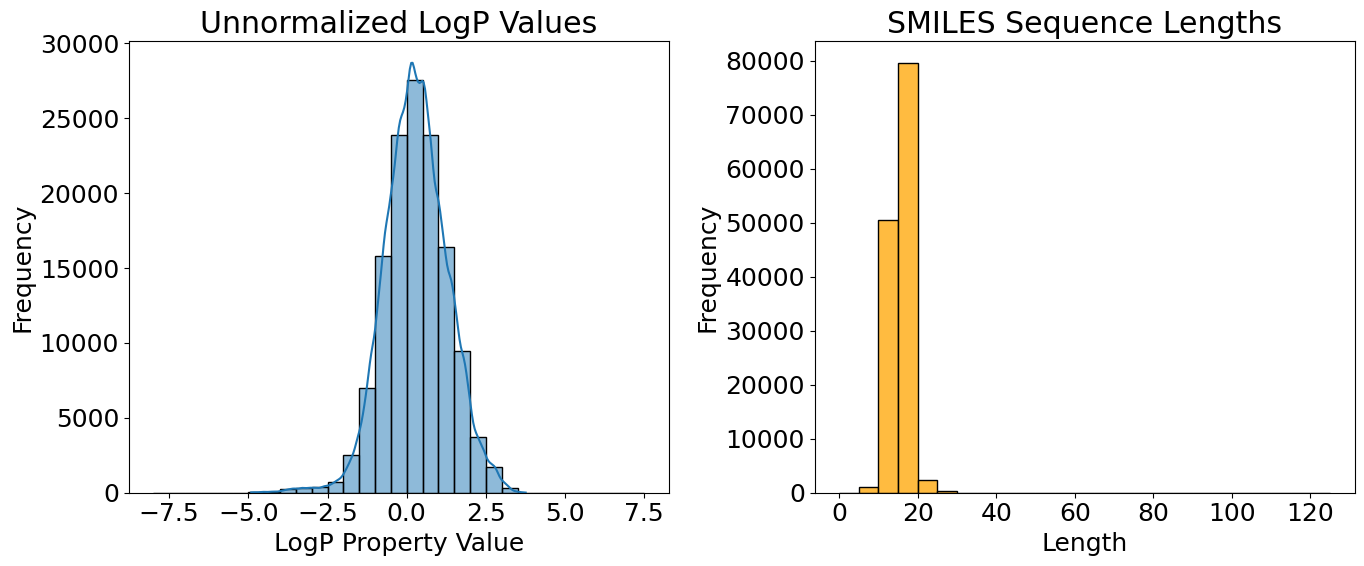

In [631]:
zinc = True
plt.rcParams.update({'font.size': 18})


if zinc:
    prop_bins = np.arange(-8, 8, 0.5)
    len_bins = np.arange(0, 130, 5)
else:
    prop_bins = np.arange(-4, 4, 0.5)
    len_bins = np.arange(0, 38, 2)


all_logp = train_props + test_props + valid_props
all_lens = [len(a) for a in (list(test_smiles) + list(train_smiles) + list(val_smiles))]

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the first histogram
sns.histplot(all_logp, bins=prop_bins ,kde=True, ax=ax[0])
ax[0].set_title('Unnormalized LogP Values')
ax[0].set_xlabel('LogP Property Value')
ax[0].set_ylabel('Frequency')

# Plot the second histogram
sns.histplot(all_lens, bins=len_bins, kde=False, color='orange', ax=ax[1])
ax[1].set_title('SMILES Sequence Lengths')
ax[1].set_xlabel('Length')
ax[1].set_ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()


In [632]:
from collections import Counter

# Count the frequency of each character
char_counter = Counter("".join(list(test_smiles) + list(val_smiles) + list(train_smiles)))

# Total number of characters
total_chars = sum(char_counter.values())

# Normalize frequencies
normalized_char_counter = {char: freq / total_chars for char, freq in char_counter.items()}

# Generate LaTeX table with characters listed vertically and frequencies in rows
latex_table = "\\begin{table}[ht]\n\\centering\n\\begin{tabular}{|c|c|c|}\n\\hline\n"
latex_table += "Character & Frequency & Normalized Frequency \\\\\n\\hline\n"
for char, freq in char_counter.items():
    latex_table += f"{char} & {freq} & {normalized_char_counter[char]:.2f} \\\\\n\\hline\n"
latex_table += "\\end{tabular}\n\\caption{Character Frequencies and Normalized Frequencies}\n\\end{table}"

print(latex_table)

\begin{table}[ht]
\centering
\begin{tabular}{|c|c|c|}
\hline
Character & Frequency & Normalized Frequency \\
\hline
C & 767830 & 0.38 \\
\hline
O & 177823 & 0.09 \\
\hline
( & 118216 & 0.06 \\
\hline
) & 118216 & 0.06 \\
\hline
# & 37027 & 0.02 \\
\hline
N & 98355 & 0.05 \\
\hline
= & 94597 & 0.05 \\
\hline
1 & 259368 & 0.13 \\
\hline
[ & 12523 & 0.01 \\
\hline
H & 10568 & 0.01 \\
\hline
3 & 35634 & 0.02 \\
\hline
+ & 1847 & 0.00 \\
\hline
] & 12523 & 0.01 \\
\hline
- & 1974 & 0.00 \\
\hline
2 & 131751 & 0.07 \\
\hline
c & 78726 & 0.04 \\
\hline
n & 41409 & 0.02 \\
\hline
o & 10174 & 0.01 \\
\hline
F & 3314 & 0.00 \\
\hline
4 & 4952 & 0.00 \\
\hline
5 & 174 & 0.00 \\
\hline
\end{tabular}
\caption{Character Frequencies and Normalized Frequencies}
\end{table}


# Metric Computation

In [633]:
# Approximate Aggregate Posterior
vae_sampler.sampling_std_div = 1.0

indices = random.sample(range(len(test_smiles)), 10000)
smiles_1k = [test_smiles[i] for i in indices]

tokens_1k = smiles_to_tokens(smiles_1k, vae_model.max_decode_steps)

z_mean, logvar = vae_model.encoder(tokens_1k)

z_mean_mean = z_mean.mean(axis=0).mean()
# print(z_mean.mean(axis=0)[:5])

est_std = z_mean.std(axis=0).mean()

print('Ideally (mean of)  z_mean should be 0!')
print('Ideally (mean of) logvar should near 0, since for N(0, 1), sigma^2 = 1, log(sigma^2) = 0')

est_vars = z_mean.var(axis=0)

print(f'Mean of mean Encodings: {z_mean_mean}')
print(f'Mean of STD of Encodings: {est_std}')

# Sample Latent Points from LSTM

old_rep = vae_model.reparam
vae_model.reparam = False
# vae_model.eval()

latents = vae_model.reparameterize(z_mean, logvar)

vae_model.reparam = old_rep

# print(np.std(latents, axis=0))
std = np.std(latents.detach().numpy(), axis=0).mean()
variance = np.var(latents.detach().numpy(), axis=0).mean()

# variance = latents.var()
# std = latents.std()

print(f'STD (Ideally Should be 1): {std}')
print(f'Variance (Ideally Should be 1): {variance}')
# print(f'Variance of mean Encodings: {est_vars}')

# print(float(est_std))
# vae_sampler.sampling_std_div = float(est_std)

Ideally (mean of)  z_mean should be 0!
Ideally (mean of) logvar should near 0, since for N(0, 1), sigma^2 = 1, log(sigma^2) = 0
Mean of mean Encodings: 0.001404350041411817
Mean of STD of Encodings: 0.22479839622974396
STD (Ideally Should be 1): 0.22478710114955902
Variance (Ideally Should be 1): 0.13609746098518372


In [634]:
props = random.sample(test_props, 50)
inp_props = torch.tensor([[a] for a in props] ).clone()
smp = vae_sampler.sample(vae_model, inp_props)
print(smp)

/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/action_sampling_vae_sampler.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  properties = torch.tensor(properties).clone()
/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()


['C#CC1OC1(CC)OC', 'O=CC1OC1COC=N2]]]]]]]]]]]]]]]]]]]]]]', 'CNC(C)C#CCC(C)]1]]]]]]]]]]]]]]]]]]]]', 'CN=C1OC2C3C=CN1C32n]]]]]]]]]]]]]]]]]', 'N#CC1CN=CNC1=N]]]]]N]]]]]]]]]n]1]]]]', 'C1OC2OCC3C(O1)C32C]]]]]]]]]1]]]]]]n]', 'COC1(C)N(C)C(N)C1C]2]]]]]]]]]]]]]]]]', 'C#CC(C)OCCO', 'COC1(C)COC1=NO]]]]]]]]]]]]]]]]]]]]]]', 'C1C2C(O)COC21OC]2]]]]]]nO]2]]]]]n]]]', 'O1C2COC3CN(C1)C23C]]]]]1]]]]]]]]]]]]', 'C1NC2OC1C1(CO1)C2C]1]]]]]]]]]]]]]]]]', 'C1N(C23CCOC2)C31]]]]]]]]]]]]]]]]]]]]', 'C#CC1COC(C)C(C)N1C]]]]]]]]]]]]]]]]]]', 'CC1C2OC(C)C(C)C12N]]]]]]]]]]]]]]]]]]', 'CC1OC2C=C1OC2=N', 'COC12NC3C(C1)N32C]]]]]]nn]]1]]nnn2]]', 'CC1C2(C)CN(CO)C123]]]]]]]]]]]]]]]]]]', 'C1OC2C1COC1(C)CC21]]]]]]]]]]C]]]C]2]', 'OC1(C2CC2)OCC1CO2]]C]2C]2]]]]]]]]]]]', 'C#CC#CC1C(C)N1)NH]]]n]]]nnn]1]]]n]]H', 'N#CC(NC)C(=N)CCO]]]]2]]]]]]]]]]]C]2]', 'C#CC1CC(C)N1CCN2]]]]]]]]]]]C]1]]]C]2', 'C1CC(C2COC=N2)CC1]]]C]]]]]]2]C]2]]]C', 'C#CCOC1CC1(C)CC2]]]]]]]]]]]]]]]]]]]]', 'C1OC2C1C=C2COC2]]C]2C]2]]]C]2]]]]C]2', 'C1C2N=CN3COC132]]]]]]]]]]]

### TODO: Train Unconditional Version

In [635]:
def compute_prior_metrics_conditional_model(model, sampler, train_set, test_props, num_sample = 1000, num_decode = 100, return_valid = False, account_unterminated=True):
    '''
    We sample 1000 latent representations z ∼ N (O, I). For each of them we decode 100 times,
    and calculate the portion of 100,000 decoded results that corresponds to valid Program or SMILES sequences.
    %Valid = #Valid / #Generations
    %Unique = #Unique Valid / #Valid
    %Novel = #Valid - #Valid_in_train_set / #Valid
    MSE = Mse (target_property - achieved_property)^2
    '''

    # TODO: Currently hardcoded for ['LogP']
    
    # Check we have enough condit. values to give to model
    assert num_sample < len(test_props)
    train_set = set(train_set.copy())
    test_props = test_props.copy()

    # Get num_sample properties
    props = random.sample(test_props, num_sample)

    n_all_smiles = 0
    n_valid_smiles = 0
    n_valid_in_train = 0
    
    valid = []

    total_me = 0

    for prop in tqdm(props):
        repeated_prop = torch.tensor([[prop]] * num_decode)
        prop_smiles = sampler.sample(model, repeated_prop.clone())

        for smi in prop_smiles:
            n_all_smiles += 1
            # Check if valid
            mol = Chem.MolFromSmiles(smi)

            if mol is not None and len(smi) < (model.max_decode_steps - 1):
                can_smi = Chem.MolToSmiles(mol, canonical=True)
                n_valid_smiles += 1
                valid.append(can_smi)

                # Compute property
                # print( (pc(mol)[0] - prop) ** 2)
                total_me += abs( pc(mol)[0] - prop) # **2 MAE is better because less sensitive to outliers
                          
                # Check if in train set
                if can_smi in train_set:
                    n_valid_in_train += 1

    # Compute metrics

    if return_valid:
        return valid

    unique_valid = set(valid)
    validity = n_valid_smiles / n_all_smiles
    uniqueness = len(unique_valid) / n_valid_smiles
    novelty = (n_valid_smiles - n_valid_in_train) / n_valid_smiles
    mse = total_me / n_valid_smiles

    assert n_all_smiles == num_sample * num_decode

    return {'validity' : validity,
            'uniqueness' : uniqueness,
            'novelty' : novelty,
            'MAE': mse}

In [636]:
compute_prior_metrics_conditional_model(vae_model, vae_sampler, train_smiles, test_props = test_props, num_sample = 1000, num_decode = 1, return_valid=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:31<00:00,  6.58it/s]


{'validity': 0.017,
 'uniqueness': 0.9411764705882353,
 'novelty': 0.7647058823529411,
 'MAE': 0.14739647058823535}

In [637]:
def compute_reconstruction_vae_model(test_smiles, test_props, vae_model, vae_sampler, n_encodes = 10, n_decodes = 25):
    '''
    test_smiles is array-like of test smiles for reconstruction
    test_props is

    n_encodes is number of encodings per test_set instance
    n_decodes is number of decodings per latent encoding

    Do one at a time since we're deconding 250x more points

    From andSD-VAE paper:
    for each of the structured data in the held-out dataset, we encode it 10 times and decoded (for each encoded latent space representation) 25 times, and report the portion of decoded structures that are the same as the input ones
    '''
    
    n_same = 0
    n_total = 0
    
    test_props = test_props.copy()
        
    # Normalize properties
    edited_props = torch.tensor([[a] for a in test_props])

    # sampler.sample already normalizes properties
    # edited_props = vae_model.normalize_prop_scores(edited_props)

    vae_model.eval()
    vae_model.reparam = True

    for smindex in tqdm(range(len(test_smiles))):
        #and max_seq_len = model.max_decode_steps
        # enc_b_size = n_encodes
        smile = test_smiles[smindex:smindex+1]
        prop = edited_props[smindex:smindex+1]

        # Convert smiles to tokens
        tokens = smiles_to_tokens(smile, vae_model.max_decode_steps)

        input_tokens = tokens.repeat(n_encodes, 1)
        input_properties = prop.repeat(n_encodes, 1)
        
        # Run through the model
        latent_points, log_var = vae_model.encoder(input_tokens)
        samp_latents = vae_model.reparameterize(mu = latent_points, logvar = log_var) # torch.tensor(vae_model.eps_std))

        # Repeat latents n_decode times
        # Repeat properties n_decode times
        samp_latents = samp_latents.repeat(n_decodes, 1) 
        repeated_props = input_properties.repeat(n_decodes, 1)

        sampled_smiles = vae_sampler.sample(model=vae_model, properties=repeated_props.clone(), random = True, latent_points = samp_latents)

        # Samp latents now contains n_encodings encoded (random latent points)
        # TODO: Do I reparam here? It's the only source of randomness for encodings but not how inference with a vae is typically done
        # feels right for judging the reconstruction loss though

        assert len(sampled_smiles) == n_encodes * n_decodes

        # Now decode probabilitically n_decode times
        counts = Counter(sampled_smiles)
        
        n_same += counts[smile[0]]

        n_total += len(sampled_smiles)

    return n_same / n_total

In [638]:
indices = random.sample(range(len(test_smiles)), 300)
smiles_1k = [test_smiles[i] for i in indices]
properties_1k = [test_props[i] for i in indices]

# Normalizes Properties
compute_reconstruction_vae_model(smiles_1k, properties_1k, vae_model, vae_sampler, n_encodes = 5, n_decodes = 5) #10 , 25


  0%|          | 0/300 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/action_sampling_vae_sampler.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_points = torch.tensor(latent_points, dtype=torch.float32)
100%|██████████| 300/300 [01:08<00:00,  4.39it/s]


0.5874666666666667

## STYLE TRANSFER

In [639]:
def style_transfer_smiles(source_smiles, target_props, vae_model, vae_sampler, b_size = 64):
    '''
    Returns generated (style transfer) smiles
    '''
    # Convert to tokens
    source_tokens = smiles_to_tokens(source_smiles, vae_model.max_decode_steps)
    target_props = torch.tensor([[a] for a in target_props]).clone()

    # Ensure model is in correct mode
    vae_model.eval()
    vae_model.reparam = True

    gen_smiles = []

    for bindex in range((target_props.shape[0] // b_size) + 1):
        b_start = bindex * b_size
        b_end = min(
            ((bindex + 1)* b_size),
            target_props.shape[0])

        stokens = source_tokens[b_start : b_end] 
        tprops = target_props[b_start : b_end]

        # Encode points
        latent_points, log_var = vae_model.encoder(stokens)

        # reparameterize/sample
        samp_latents = vae_model.reparameterize(mu = latent_points, logvar = log_var)

        # Decode with target prop
        gen_smiles += vae_sampler.sample(
            model=vae_model, 
            properties=tprops.clone(), 
            random = True, 
            latent_points = samp_latents
            )

    return gen_smiles

In [640]:
def compute_mean_property_error(properties_1, properties_2):
    '''
    Mae between two lists of properties 
    
    - ignoring indecies where either property is None
    '''
    total_mae = 0
    n_valid = 0

    assert len(properties_1) == len(properties_2)
    for i in range(len(properties_1)):
        if properties_1[i] is None or properties_2[i] is None:
            continue
        else:
            n_valid += 1
            # Compute MAE between generated LogP and original LogP
            total_mae += abs(properties_1[i] - properties_2[i])

    return total_mae / n_valid

In [641]:
def compute_avg_similarity(smiles_1, smiles_2, morgan_radius=2, ignore_same = True):
    '''
    Comptues average tanimoto similarity between two ordered lists of smiles

    - Ignores invalid pairs
    - If ignore_same, ignores cases where the smiles are the same (cases where style transfer has failed)
    '''

    n_fails = 0
    assert len(smiles_1) == len(smiles_2)

    similarities = []
    n_valid = 0

    for i in range(len(smiles_1)):
        mol1 = Chem.MolFromSmiles(smiles_1[i])
        mol2 = Chem.MolFromSmiles(smiles_2[i])

        # Check validity
        if mol1 is None or mol2 is None:
            continue
        
        if ignore_same:
            can_smi1 = Chem.MolToSmiles(mol1, canonical=True)
            can_smi2 = Chem.MolToSmiles(mol2, canonical=True)

            if can_smi1 == can_smi2:
                n_fails += 1
                continue
                

        # Get fingerprints
        fing1 = AllChem.GetMorganFingerprint(mol1, radius=morgan_radius)
        fing2 = AllChem.GetMorganFingerprint(mol2, radius=morgan_radius)

        similarities.append(DataStructs.TanimotoSimilarity(fing1, fing2))
        n_valid += 1

    pct_same = n_fails / n_valid
    print(f'Ignored {pct_same} % failed style transfer molecules')
    
    return sum(similarities) / n_valid


In [642]:
# PARAMETERS
n_samp = 2500

# Ensure we have enough smiles
assert 4 * n_samp <= len(test_smiles)

# Sample indices
all_indices = random.sample(range(len(test_smiles)), n_samp * 4)

# SAMPLE NON-OVERLAPPING INDICES
source_indices = all_indices[:n_samp]
target_indices = all_indices[n_samp:2*n_samp]
rand_dset_indices = all_indices[2*n_samp:3*n_samp]
rand_dec_indices = all_indices[3*n_samp:]


# Sample Source smiles to perform style transfer on
# source_indices = random.sample(range(len(test_smiles)), n_samp)
source_smiles = [test_smiles[i] for i in source_indices]
source_props = [test_props[i] for i in source_indices]

# Sample Target properties (and smiles) to transfer onto source molecules
# target_indices = random.sample(range(len(test_smiles)), n_samp)
target_smiles = [test_smiles[i] for i in target_indices]
target_props = [test_props[i] for i in target_indices]

# Perform Style Transfer
generated_smiles = style_transfer_smiles(source_smiles, target_props, vae_model, vae_sampler)

# Compute properties for style transfer results
generated_mols = [ Chem.MolFromSmiles(a) for a in generated_smiles]
generated_props = [ None if a is None else pc(a)[0] for a in generated_mols]

# Sample random [dataset] properties and smiles 
# rand_dset_indices =  random.sample(range(len(test_smiles)), n_samp)
rand_dset_smiles = [test_smiles[i] for i in rand_dset_indices]
rand_dset_props = [test_props[i] for i in rand_dset_indices]

# random [decoder | dataset] properties and smiles
# rand_dec_indices = random.sample(range(len(test_smiles)), n_samp)
rand_dec_input_props = [test_props[i] for i in rand_dec_indices]
rand_dec_input_props_formatted = torch.tensor([[a] for a in rand_dec_input_props])

rand_dec_smiles = vae_sampler.sample(model=vae_model, properties=rand_dec_input_props_formatted)
rand_dec_mols = [ Chem.MolFromSmiles(a) for a in rand_dec_smiles]
rand_dec_props = [ None if a is None else pc(a)[0] for a in rand_dec_mols]

In [643]:
# Style transfer validity
st_valid = (len(generated_props) - generated_props.count(None)) / len(generated_props)
print(f'Style Transfer Validity: {st_valid}')

Style Transfer Validity: 0.1808


In [644]:
'''
MEAN ERROR BETWEEN SOURCE PROPERTIES AND GENERATED PROPERTIES
 - Ideally should be bad, close to mean error between random decoder and dataset properties
'''

'''
mae_source_gen = compute_mean_property_error(source_props, generated_props)
print(f' MAE Between Generated and Source properties (should be close to random): {mae_source_gen}\n')
'''

'''
MEAN ERROR BETWEEN RANDOM DATASET PROPERTIES AND DECODER PROPERTIES
 - Benchmark for source - generated error
'''

'''
mae_random_dset_gen = compute_mean_property_error(rand_dec_props, rand_dset_props)
print('NOTE: I question this metric.')
print(f' MAE Between random dataset properties and random decoder properties: {mae_random_dset_gen}\n')
'''

# print()
# print()
# print()

'''
MEAN ERROR BETWEEN TARGET PROPERTIES AND GENERATED PROPERTIES
 - Should be as small as possible, ideally equal to the mean error for conditional generation
'''

mae_target_gen = compute_mean_property_error(target_props, generated_props)
print(f' MAE Between Generated and Target properties (should be small; close to cond_gen performance): {mae_target_gen}\n')

'''
MEAN ERROR FOR CONDITIONAL GENERATION
'''
# mae_cond_gen = compute_mean_property_error(rand_dec_input_props, rand_dec_props)
# print(f' Cond Gen MAE: {mae_cond_gen}\n')


 MAE Between Generated and Target properties (should be small; close to cond_gen performance): 0.20445223451327432



'\nMEAN ERROR FOR CONDITIONAL GENERATION\n'

In [645]:
morgan_rad = 3

'''
SIMILARITY BETWEEN TARGET SMILES AND GENERATED SMILES
Should be low, ideally near the similarity of random smiles from the decoder with random smiles from the generator
'''
'''
sim_tgt_gen = compute_avg_similarity(target_smiles, generated_smiles, morgan_radius=morgan_rad)
print(f'Similarity between target and geneated smiles (Should be as low as possible): {sim_tgt_gen}')
'''

'''
SIMILARITY BETWEEN SOURCE SMILES AND GENERATED SMILES
Should be as high as possible
'''

sim_source_gen = compute_avg_similarity(source_smiles, generated_smiles, morgan_radius=morgan_rad, ignore_same=True)
print(f'Similarity between source and geneated smiles (Should be as high as possible): {sim_source_gen}')


# print('\n\n')

'''
Similarity of random decoder with random dataset smiles
'''
'''
sim_rdn_dec_dset = compute_avg_similarity(rand_dec_smiles, rand_dset_smiles, morgan_radius=morgan_rad)
'''
# print(f'Similarity between random decoder and dataset smiles (Random Baseline): {sim_rdn_dec_dset}')

'''
Percentage of cases in witch style transfer fails and the decoder reproduces the source molecules
'''
n_valid = 0
n_fail = 0
for i in range(len(source_smiles)):
    # Ignore invalid
    if generated_props[i] is None:
        continue
    n_valid += 1
    if generated_smiles[i] == source_smiles[i]:
        n_fail += 1

pct_fail = n_fail / n_valid

print('\n')
print(f'PCT Failure to change source molecule: {pct_fail}')

Ignored 1.8074534161490683 % failed style transfer molecules
Similarity between source and geneated smiles (Should be as high as possible): 0.3448745490620726


PCT Failure to change source molecule: 0.6438053097345132


In [646]:
morgan_rad=3

'''0.11363633864974969
Tanimoto baseline 1: Similarity between random latents decoded with target property and source molecules
'''

latent_gen_smiles = vae_sampler.sample(
            model=vae_model,
            properties=torch.tensor( [ [a] for a in target_props]).clone(), 
            random = True,
            latent_points = None
            )

baseline_1_sim = compute_avg_similarity(smiles_1= latent_gen_smiles, smiles_2= source_smiles , morgan_radius=morgan_rad, ignore_same = True)
print(f'Baseline 1 -- Source smiles x random latent smiles:  {baseline_1_sim} (ignoring failure: {True})')


'''
Tanimoto baseline 2: Similarity between random molecules decoded with target property and source molecules
'''

rand_gen_smiles = style_transfer_smiles(
                        source_smiles=rand_dset_smiles,
                        target_props=target_props,
                        vae_model=vae_model,
                        vae_sampler = vae_sampler
                        )


baseline_2_sim = compute_avg_similarity(smiles_1= rand_gen_smiles, smiles_2= source_smiles , morgan_radius=morgan_rad, ignore_same = True)
print(f'Baseline 2 -- Source smiles x ST of random smiles:  {baseline_2_sim} (ignoring failure: {True})')

Ignored 0.0 % failed style transfer molecules
Baseline 1 -- Source smiles x random latent smiles:  0.056981225938898296 (ignoring failure: True)
Ignored 0.0 % failed style transfer molecules
Baseline 2 -- Source smiles x ST of random smiles:  0.06508621122334654 (ignoring failure: True)


In [431]:
def compute_sim(mol1, mol2, radius = 3):
    # Check validity
    if mol1 is None or mol2 is None:
        return None
        
    fing1 = AllChem.GetMorganFingerprint(mol1, radius=radius)
    fing2 = AllChem.GetMorganFingerprint(mol2, radius=radius)

    return DataStructs.TanimotoSimilarity(fing1, fing2)

In [436]:
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

def plot_style_transfer_2(og_smiles, og_props, random_props, st_smiles, st_props, filename= None, font_size = 22, draw_tans = True):
    """
    Plots a comparison of original and style-transferred SMILES molecules,
    skipping entries where the style-transferred property is None or SMILES
    cannot be converted to a molecule object.

    Parameters:
    - og_smiles: List of original SMILES strings sampled from the dataset.
    - og_props: List of original properties corresponding to the original SMILES.
    - random_props: List of random properties used for style transfer sampled from the dataset.
    - st_smiles: List of SMILES strings after style transfer.
    - st_props: List of properties for the style-transferred SMILES.
    """
    
    filtered_indices = [i for i in range(len(st_props)) if st_props[i] is not None]

    # Create a subplot of n rows and 3 columns, checking the count of valid entries
    n = len(filtered_indices)
    if n == 0:
        print("No valid entries to plot.")
        return

    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(15, n * 3))
    if n == 1:  # Adjust axes array for single subplot scenario
        axes = [axes]

    row = 0
    for i in filtered_indices:
        og_mol = Chem.MolFromSmiles(og_smiles[i])
        st_mol = Chem.MolFromSmiles(st_smiles[i])

        if og_mol is None or st_mol is None:
            continue  # Skip if any molecule could not be generated

        og_img = Draw.MolToImage(og_mol)
        st_img = Draw.MolToImage(st_mol)

        # Plot original molecule
        axes[row, 0].imshow(og_img)
        axes[row, 0].axis('off')
        axes[row, 0].set_title(f'Source Molecule \n LogP: {round(og_props[i], 4)}')

        # Plot target logP
        axes[row, 1].text(0.5, 0.5, f'LogP: {round(random_props[i], 4)}', 
                          horizontalalignment='center', 
                          verticalalignment='center', 
                          fontsize=font_size, 
                          bbox=dict(facecolor='white', alpha=0.5))

        axes[row, 1].axis('off')
        axes[row, 1].set_title('Target Property Value')

        # Plot style transferred molecule
        axes[row, 2].imshow(st_img)
        axes[row, 2].axis('off')

        if not draw_tans:
            axes[row, 2].set_title(f'Generated Molecule \n LogP: {round(st_props[i], 4)}')
        if draw_tans:
            sim = round(compute_sim(og_mol, st_mol), 2)
            axes[row, 2].set_title(f'Generated Molecule \n LogP: {round(st_props[i], 4)} \n (Tan. Sim. {sim})')
            # axes[row, 2].text(0.5, -0.15, f'(Tan. Sim. {sim})', transform=axs[i].transAxes, fontsize=small_font_size, ha='center', va='top')

        # Draw arrows and plus sign
        fig.text(0.35, (n - row - 0.5) / n, '+', fontsize=20, ha='center', va='center')
        fig.text(0.64, (n - row - 0.5) / n, '→', fontsize=20, ha='center', va='center')

        row += 1  # Increment row counter only when a pair is actually plotted
    plt.subplots_adjust(wspace=-0.3) 
    plt.rcParams.update({'font.size': font_size - 3})
    plt.tight_layout()
    if filename == None:
        plt.show()
    else:
        plt.savefig(filename)

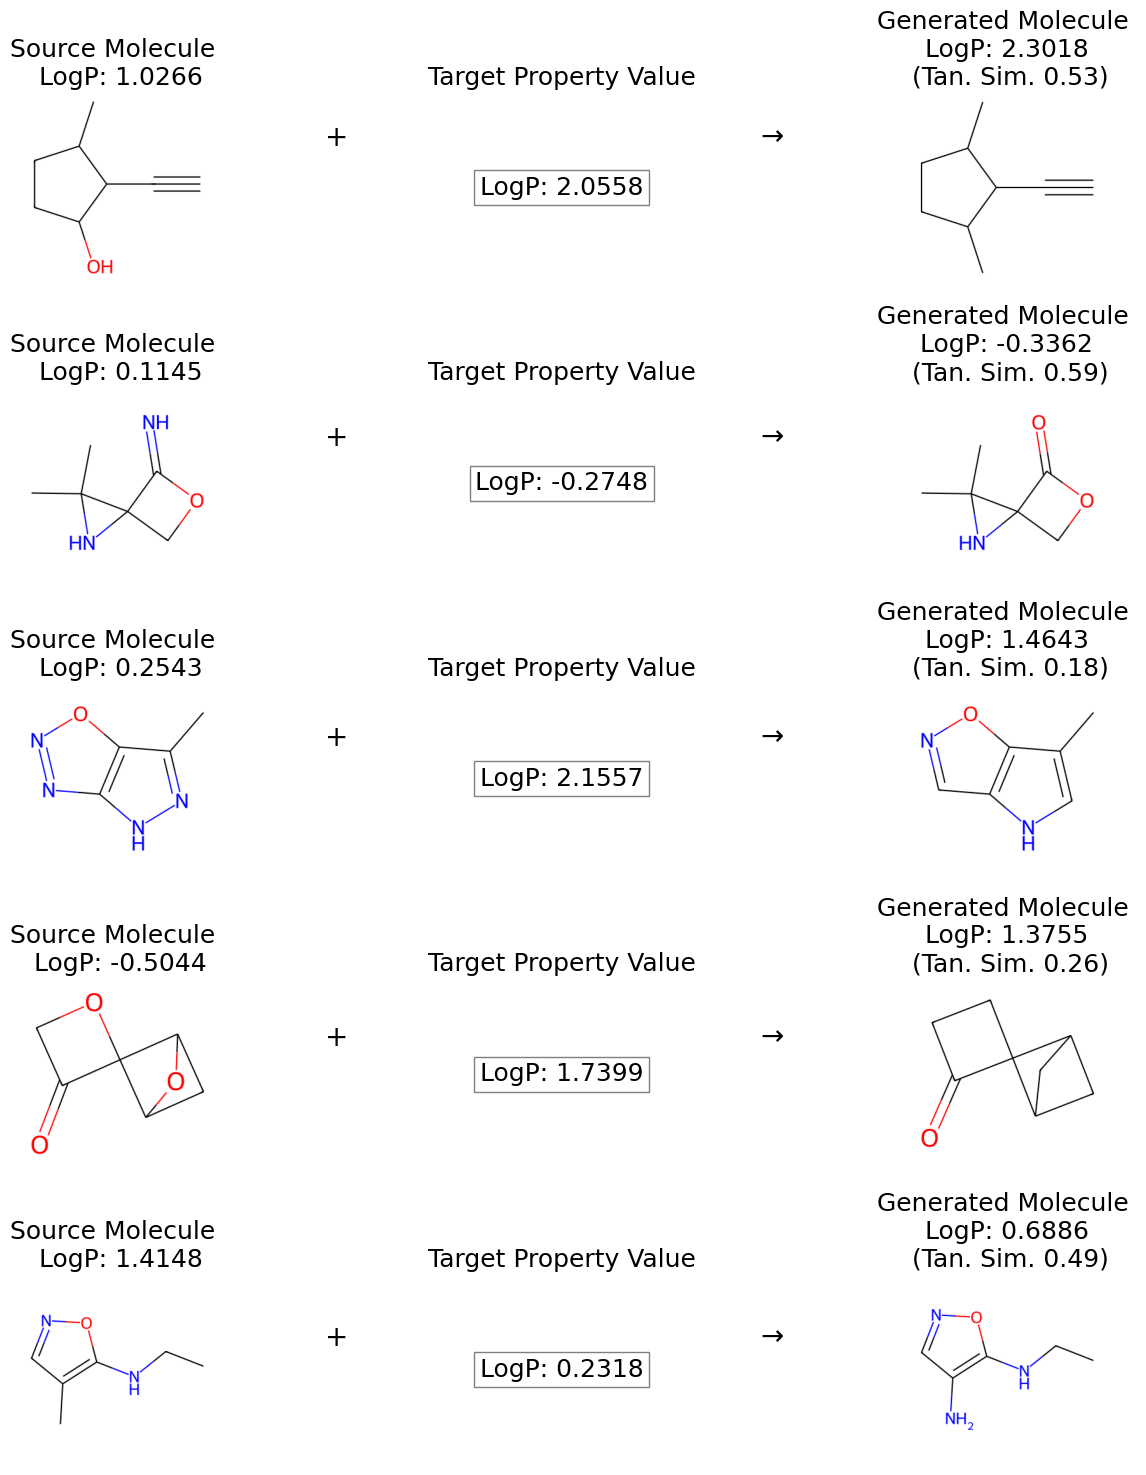

In [467]:
# Good indices 51, 30, 10, 11, 15
i1 = 2 #  #  1011 # 51
i2 = 9 # 10 #  1233 # 31
i3 = 5 # 9 # 40 # 11
i4 = 10 # 4 # 15
i5 = 4 # 2 # 12

good_og_source = [source_smiles[i1], source_smiles[i2], source_smiles[i3], source_smiles[i4], source_smiles[i5]]
good_og_props =  [source_props[i1], source_props[i2], source_props[i3], source_props[i4], source_props[i5]]
good_target = [target_props[i1], target_props[i2], target_props[i3], target_props[i4], target_props[i5]]
good_st_smiles = [generated_smiles[i1], generated_smiles[i2], generated_smiles[i3], generated_smiles[i4], generated_smiles[i5]]
good_st_props = [generated_props[i1], generated_props[i2], generated_props[i3], generated_props[i4], generated_props[i5]]


plot_style_transfer_2(
    og_smiles = good_og_source,
    og_props = good_og_props,
    random_props = good_target,
    st_smiles = good_st_smiles,
    st_props = good_st_props,
    filename = "./Selected_ST_EXP_Pol2_V5.pdf", # "./Selected_ST_EXP_Pol2_V2.pdf", # None,
    font_size = 18,
    draw_tans = True) # )

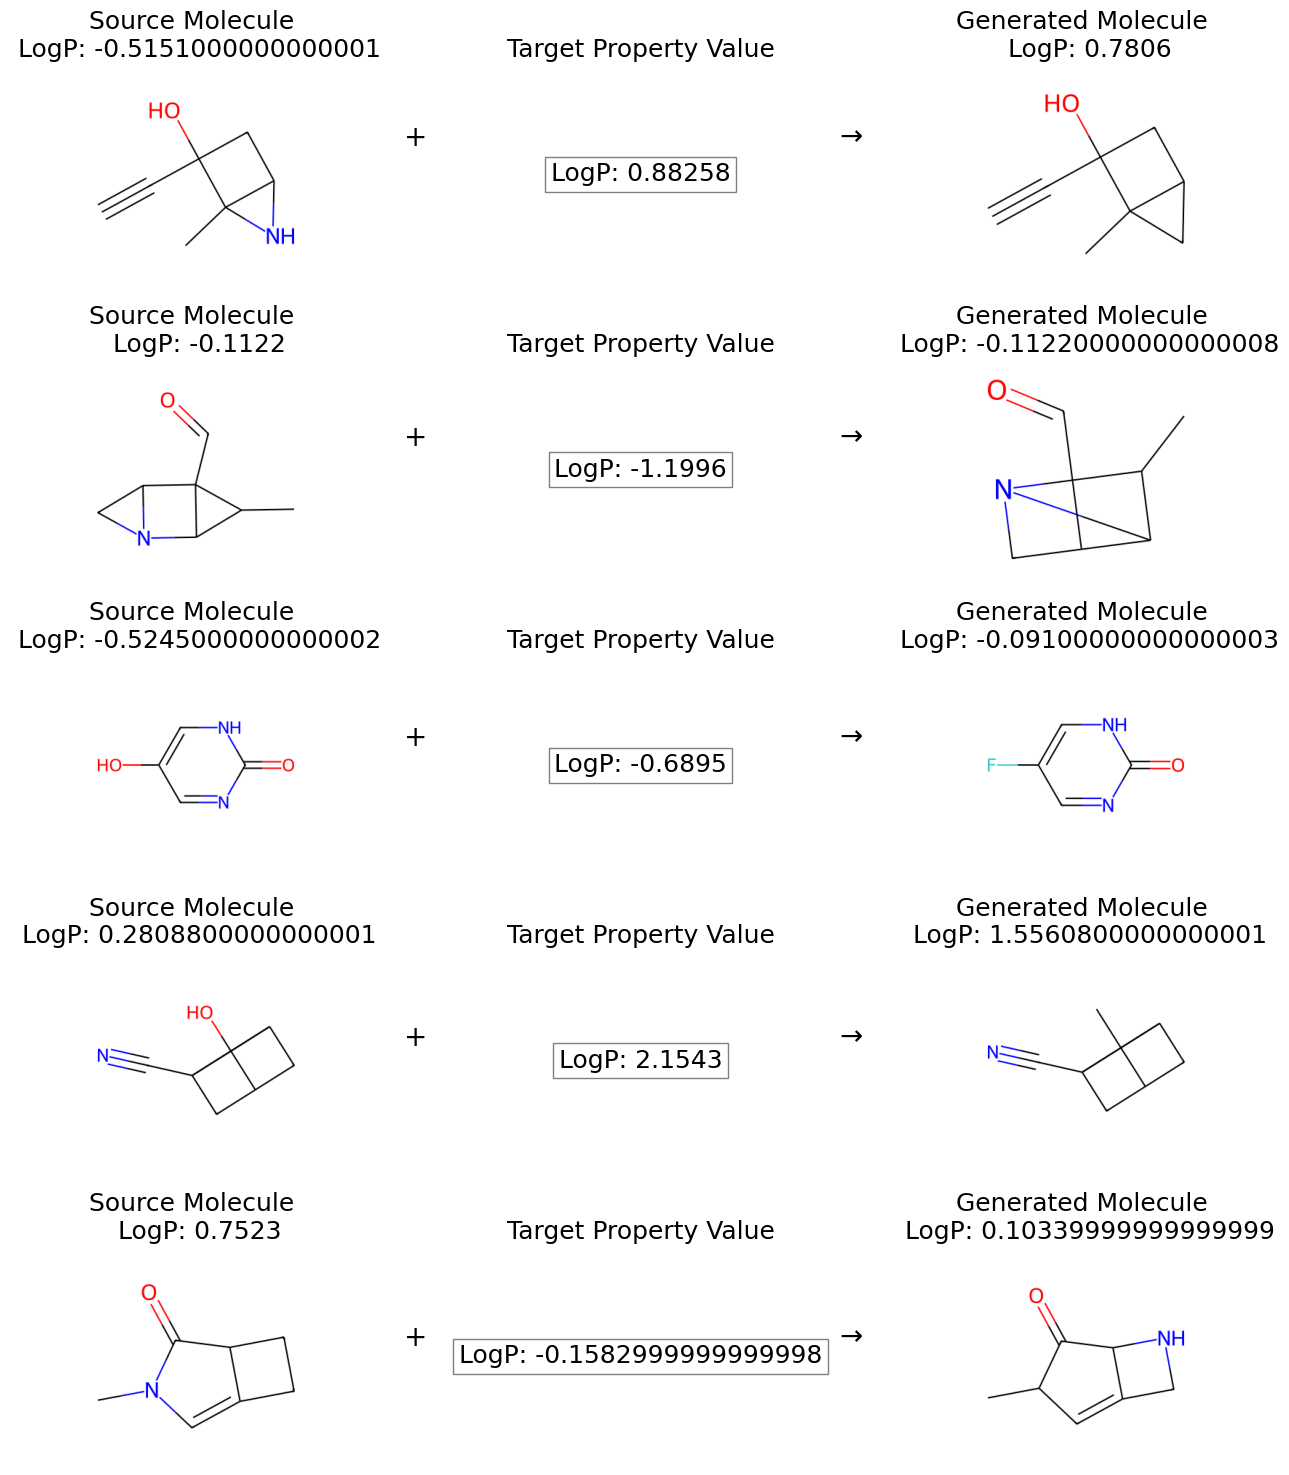

In [371]:
n_to_plot = 5
offset = 21

plot_style_transfer_2(
    og_smiles = source_smiles[offset:offset+n_to_plot],
    og_props = source_props[offset:offset+n_to_plot],
    random_props = target_props[offset:offset+n_to_plot],
    st_smiles = generated_smiles[offset:offset+n_to_plot],
    st_props = generated_props[offset:offset+n_to_plot],
    filename = None,
    font_size = 18)


In [338]:
# Load Explicit cVAE Model

# TODO: FIX NAME CLASHES
file_path = 'ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py'

# Load the module specified by the file path
spec = importlib.util.spec_from_file_location("model_vanilla_vae.py", file_path)
module = importlib.util.module_from_spec(spec)
sys.modules["model_vanilla_vae"] = module
spec.loader.exec_module(module)

explicit_model_class = module.VanillaMolVAE

file_path = 'ACTION_SAMPLING_VANILLA_VAE/action_sampling_vae_sampler.py'

# Load the module specified by the file path
spec = importlib.util.spec_from_file_location("action_sampling_vae_sampler.py", file_path)
module = importlib.util.module_from_spec(spec)
sys.modules["action_sampling_vae_sampler"] = module
spec.loader.exec_module(module)

harness_class = module.VanillaVAEHarness

model_definit = 'models/GB_PARAMS/QM9/EXP/EXP-cVAE/SD_REG_VANILLA_VAE_wandering-flower-97_Epoch_286_Vl_0.038.json'   # 'models/NARROW_SAMPLING_LONG_RUNS/QM9/EXP-cVAE-TF10/SD_REG_VANILLA_VAE_bold-bonus-90_Epoch_216_Vl_0.034.json'
model_weights = 'models/GB_PARAMS/QM9/EXP/EXP-cVAE/SD_REG_VANILLA_VAE_wandering-flower-97_Epoch_286_Vl_0.038.pt'     # 'models/NARROW_SAMPLING_LONG_RUNS/QM9/EXP-cVAE-TF10/SD_REG_VANILLA_VAE_bold-bonus-90_Epoch_216_Vl_0.034.pt'

exp_cvae_sampler = harness_class(batch_size=64, device='cpu')
exp_cvae_model = load_model(model_class=explicit_model_class, model_definition=model_definit, model_weights=model_weights, device='cpu')


model_definit = 'models/GB_PARAMS/QM9/EXP/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_patient-paper-65_Epoch_215_Vl_0.268.json'
model_weights = 'models/GB_PARAMS/QM9/EXP/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_patient-paper-65_Epoch_215_Vl_0.268.pt'

exp_cvae_kld_sampler = harness_class(batch_size=64, device='cpu')
exp_cvae_kld_model = load_model(model_class=explicit_model_class, model_definition=model_definit, model_weights=model_weights, device='cpu')

model_definit = 'models/GB_PARAMS/QM9/EXP/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_dark-sun-13_Epoch_296_Vl_0.375.json'
model_weights = 'models/GB_PARAMS/QM9/EXP/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_dark-sun-13_Epoch_296_Vl_0.375.pt'

exp_cvae_pol2_sampler = harness_class(batch_size=64, device='cpu')
exp_cvae_pol2_model = load_model(model_class=explicit_model_class, model_definition=model_definit, model_weights=model_weights, device='cpu')


####### TF MODELS #######

model_definit = 'models/GB_PARAMS/QM9/TF/TF-cVAE/SD_REG_VANILLA_VAE_young-shape-74_Epoch_314_Vl_0.028.json'
model_weights = 'models/GB_PARAMS/QM9/TF/TF-cVAE/SD_REG_VANILLA_VAE_young-shape-74_Epoch_314_Vl_0.028.pt'

tf_cvae_sampler = harness_class(batch_size=64, device='cpu')
tf_cvae_model = load_model(model_class=explicit_model_class, model_definition=model_definit, model_weights=model_weights, device='cpu')

model_definit = 'models/GB_PARAMS/QM9/TF/TF-cVAE-KLD/SD_REG_VANILLA_VAE_yellow-pine-00_Epoch_193_Vl_0.175.json'
model_weights = 'models/GB_PARAMS/QM9/TF/TF-cVAE-KLD/SD_REG_VANILLA_VAE_yellow-pine-00_Epoch_193_Vl_0.175.pt'

tf_cvae_kld_sampler = harness_class(batch_size=64, device='cpu')
tf_cvae_kld_model = load_model(model_class=explicit_model_class, model_definition=model_definit, model_weights=model_weights, device='cpu')

model_definit = 'models/GB_PARAMS/QM9/TF/TF-cVAE-Pol2/SD_REG_VANILLA_VAE_morning-rain-50_Epoch_235_Vl_0.279.json'
model_weights = 'models/GB_PARAMS/QM9/TF/TF-cVAE-Pol2/SD_REG_VANILLA_VAE_morning-rain-50_Epoch_235_Vl_0.279.pt'

tf_cvae_pol2_sampler = harness_class(batch_size=64, device='cpu')
tf_cvae_pol2_model = load_model(model_class=explicit_model_class, model_definition=model_definit, model_weights=model_weights, device='cpu')


a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited
a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited
a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited
a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited
a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited
a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


In [165]:
# PARAMETERS
n_samp = 500

# Ensure we have enough smiles
assert 4 * n_samp <= len(test_smiles)

# Sample indices
all_indices = random.sample(range(len(test_smiles)), n_samp * 4)

# SAMPLE NON-OVERLAPPING INDICES
source_indices = all_indices[:n_samp]
target_indices = all_indices[n_samp:2*n_samp]
rand_dset_indices = all_indices[2*n_samp:3*n_samp]
rand_dec_indices = all_indices[3*n_samp:]


# Sample Source smiles to perform style transfer on
# source_indices = random.sample(range(len(test_smiles)), n_samp)
source_smiles = [test_smiles[i] for i in source_indices]
source_props = [test_props[i] for i in source_indices]

# Sample Target properties (and smiles) to transfer onto source molecules
# target_indices = random.sample(range(len(test_smiles)), n_samp)
target_smiles = [test_smiles[i] for i in target_indices]
target_props = [test_props[i] for i in target_indices]

# Perform Style Transfer
generated_smiles_cvae_tf = style_transfer_smiles(source_smiles, target_props, exp_cvae_model, exp_cvae_sampler)

# Compute properties for style transfer results
generated_mols_cvae_tf = [ Chem.MolFromSmiles(a) for a in generated_smiles_cvae_tf]
generated_props_cvae_tf = [ None if a is None else pc(a)[0] for a in generated_mols_cvae_tf]


# Perform Style Transfer
generated_smiles_kld = style_transfer_smiles(source_smiles, target_props, exp_cvae_kld_model, exp_cvae_tf_sampler)

# Compute properties for style transfer results
generated_mols_kld = [ Chem.MolFromSmiles(a) for a in generated_smiles_kld]
generated_props_kld = [ None if a is None else pc(a)[0] for a in generated_mols_kld]

'''
indices = [i for i in range(len(generated_props_kld)) if generated_props_cvae_tf[i] is not None and generated_props_kld is not None ]
print(indices)

indices = np.where((generated_props_kld != None) & (generated_props_cvae_tf != None))[0]
indices
'''

/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/action_sampling_vae_sampler.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  properties = torch.tensor(properties).clone()
/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/action_sampling_vae_sampler.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_points = torch.tensor(latent_points, dtype=torch.float32)
/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tens

/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/action_sampling_vae_sampler.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  properties = torch.tensor(properties).clone()
/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/action_sampling_vae_sampler.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_points = torch.tensor(latent_points, dtype=torch.float32)
/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tens

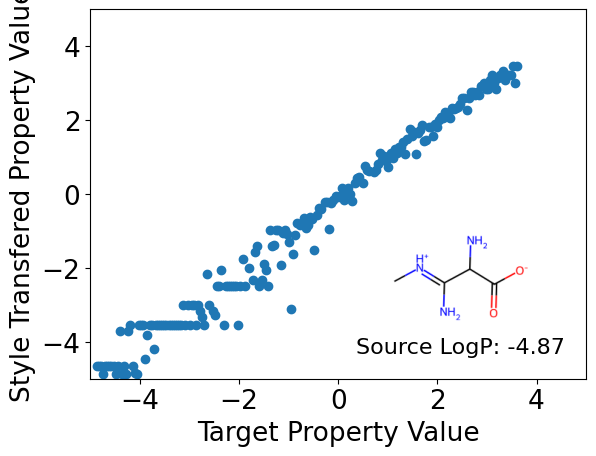

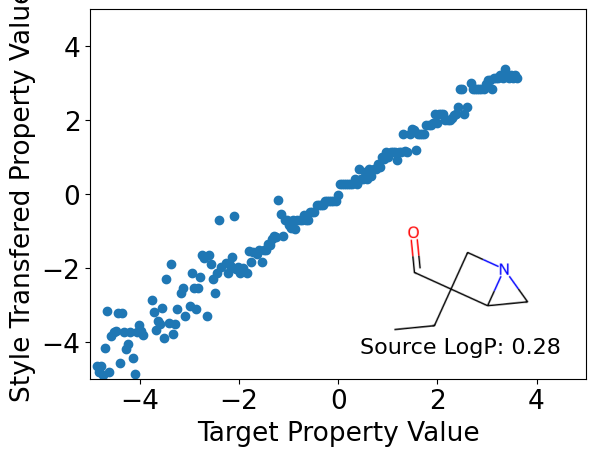

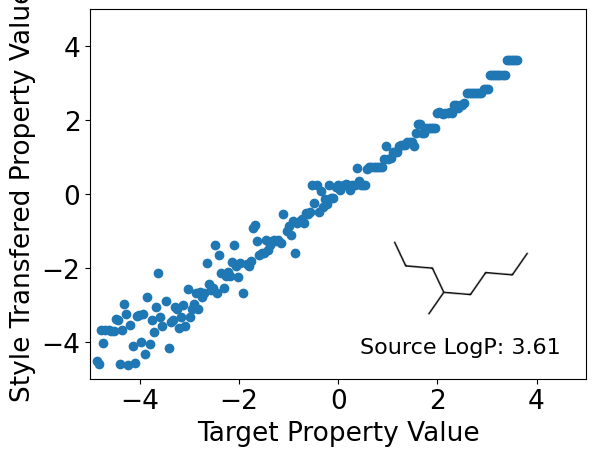

In [346]:
from rdkit.Chem import Descriptors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

mindex = 7241
maxdex = 9117
meddex = 7883
n_points = 200
# max([i if np.median(np.array(test_props)) == test_props[i] else 0 for i in range(len(test_props))])

mdl_name = 'TF-Pol2' # 'Pol2' # None 'KLD' 'Pol2'

for mid in ['min', 'med', 'max']:
    if mdl_name == None:
        model = exp_cvae_model
        sampler = exp_cvae_sampler
    elif mdl_name == 'KLD':
        model = exp_cvae_kld_model
        sampler = exp_cvae_kld_sampler
    elif mdl_name == 'Pol2':
        model = exp_cvae_pol2_model
        sampler = exp_cvae_kld_sampler
    if mdl_name == 'TF':
        model = tf_cvae_model
        sampler = tf_cvae_sampler
    elif mdl_name == 'TF-KLD':
        model = tf_cvae_kld_model
        sampler = tf_cvae_kld_sampler
    elif mdl_name == 'TF-Pol2':
        model = tf_cvae_pol2_model
        sampler = tf_cvae_kld_sampler

    if mid == 'min':
        index = mindex
    if mid == 'med':
        index = meddex
    if mid == 'max':
        index = maxdex


    trange = np.linspace(min(test_props), max(test_props), n_points)
    tprops = torch.tensor([[a] for a in trange])

    ssmiles  = np.repeat(test_smiles[index] ,  n_points)
    gsmiles = style_transfer_smiles(ssmiles, tprops, model, sampler, b_size=64)

    # Compute properties for style transfer results
    gmols = [ Chem.MolFromSmiles(a) for a in gsmiles]
    gprops = [ None if a is None else pc(a)[0] for a in gmols]


    if mid == 'min':
        tsmi_min = test_smiles[index]
        gprops_min = gprops
    if mid == 'med':
        tsmi_med = test_smiles[index]
        gprops_med = gprops
    if mid == 'max':
        tsmi_max = test_smiles[index]
        gprops_max = gprops

    font_size = 18
    small_font_size = 16

    if mid == 'min':
        target_smile = tsmi_min
        target_props = gprops_min
    if mid == 'med':
        target_smile = tsmi_med
        target_props = gprops_med
    if mid == 'max':
        target_smile = tsmi_max
        target_props = gprops_max

    molecule = Chem.MolFromSmiles(target_smile)

    # Calculate LogP
    logP = Descriptors.MolLogP(molecule)

    # Create larger molecular image
    from rdkit.Chem.Draw import DrawingOptions
    DrawingOptions.bondLineWidth = 100.0

    molecular_image = Draw.MolToImage(molecule, size=(200, 200))  # Increase the size

    # molecular_image = mol_to_image_with_thick_lines(molecule)
    # Create scatter plot
    fig, ax = plt.subplots()

    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)


    ax.scatter(trange, target_props)
    ax.set_xlabel('Target Property Value')
    ax.set_ylabel('Style Transfered Property Value')
    # ax.set_title('Style Transfer performance for Target Property Range')

    # Create inset axis for the molecular image
    inset_ax = inset_axes(ax, width="40%", height="40%", loc='lower right', borderpad=1)  # Adjust width and height
    inset_ax.text(0.5, 0.1, f'Source LogP: {logP:.2f}', fontsize=small_font_size, ha='center', va='top', transform=inset_ax.transAxes)

    # Display molecular image in the inset axis
    inset_ax.imshow(molecular_image)
    inset_ax.axis('off') 

    if mid == 'min':
        min_logp = logP
        fig_min = fig
        ax_min = ax
        min_image = molecular_image
    if mid == 'med':
        med_logp = logP
        fig_med = fig
        ax_med = ax
        med_image = molecular_image
    if mid == 'max':
        max_logp = logP
        fig_max = fig
        ax_max = ax
        max_image = molecular_image


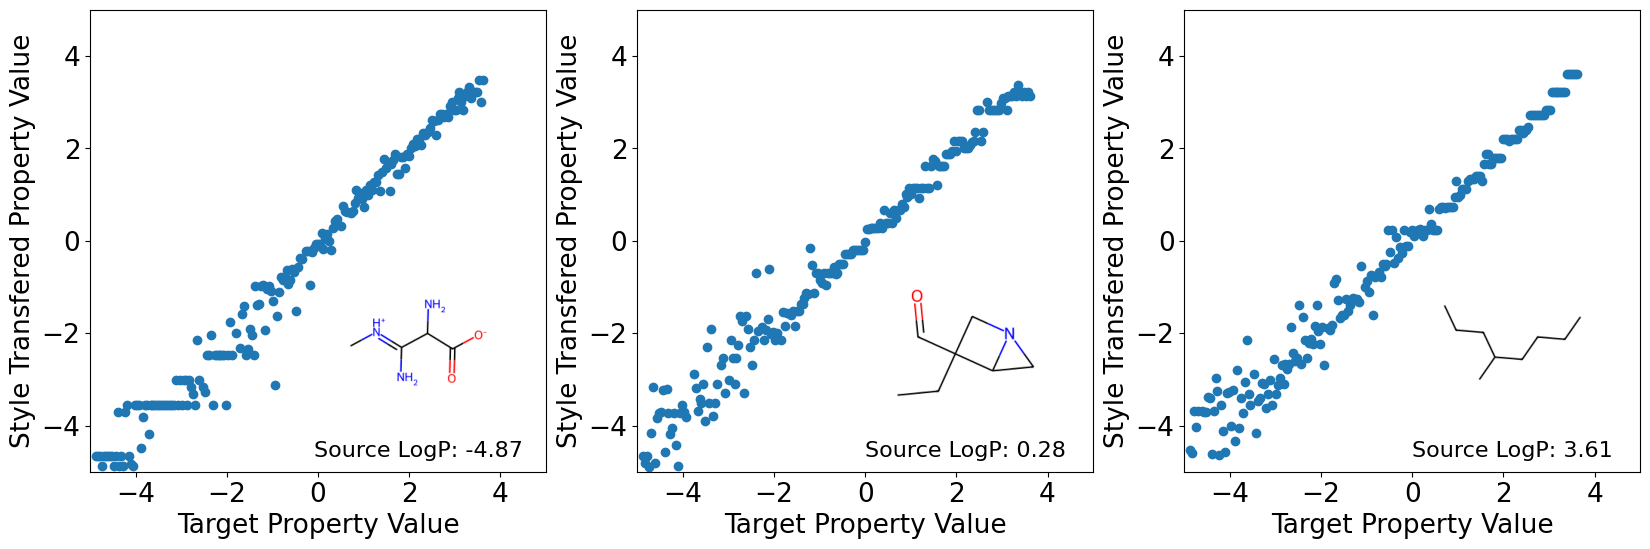

In [347]:
prop_arrays = [gprops_min, gprops_med, gprops_max]
mimages = [min_image, med_image, max_image]
logps = [min_logp, med_logp, max_logp]

fig_title = 'ST_Range_TF-cVAE-Pol2_V5.pdf' # 'ST_Range_EXP-cVAE-KLD.pdf' # None # 'ST_Range_EXP-cVAE.pdf'

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': font_size + 1})

# Create a new figure with 1 row and 3 columns for subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Plot each figure in the subplots
for i in range(3):
    axs[i].scatter(trange, prop_arrays[i], zorder=2)
    axs[i].set_xlabel('Target Property Value')
    axs[i].set_ylabel('Style Transfered Property Value')
    # axs[i].set_title('Style Transfer performance for various properties')
    axs[i].set_xlim(-5, 5)
    axs[i].set_ylim(-5, 5)

    inset_ax = inset_axes(axs[i], width="33%", height="33%", loc='lower right', borderpad=2.0)  # Adjust width and height
    inset_ax.imshow(mimages[i])
    inset_ax.axis('off')  # Hide the axis
    inset_ax.text(0.5, -0.15, f'Source LogP: {logps[i]:.2f}', fontsize=small_font_size, ha='center', va='top', transform=inset_ax.transAxes)
    

# Show the combined figure with horizontally stacked plots
if fig_title == None:
    plt.show()
else:
    plt.savefig(fig_title)

In [105]:
exp_cvae_kld_tf_model.max_decode_steps

101

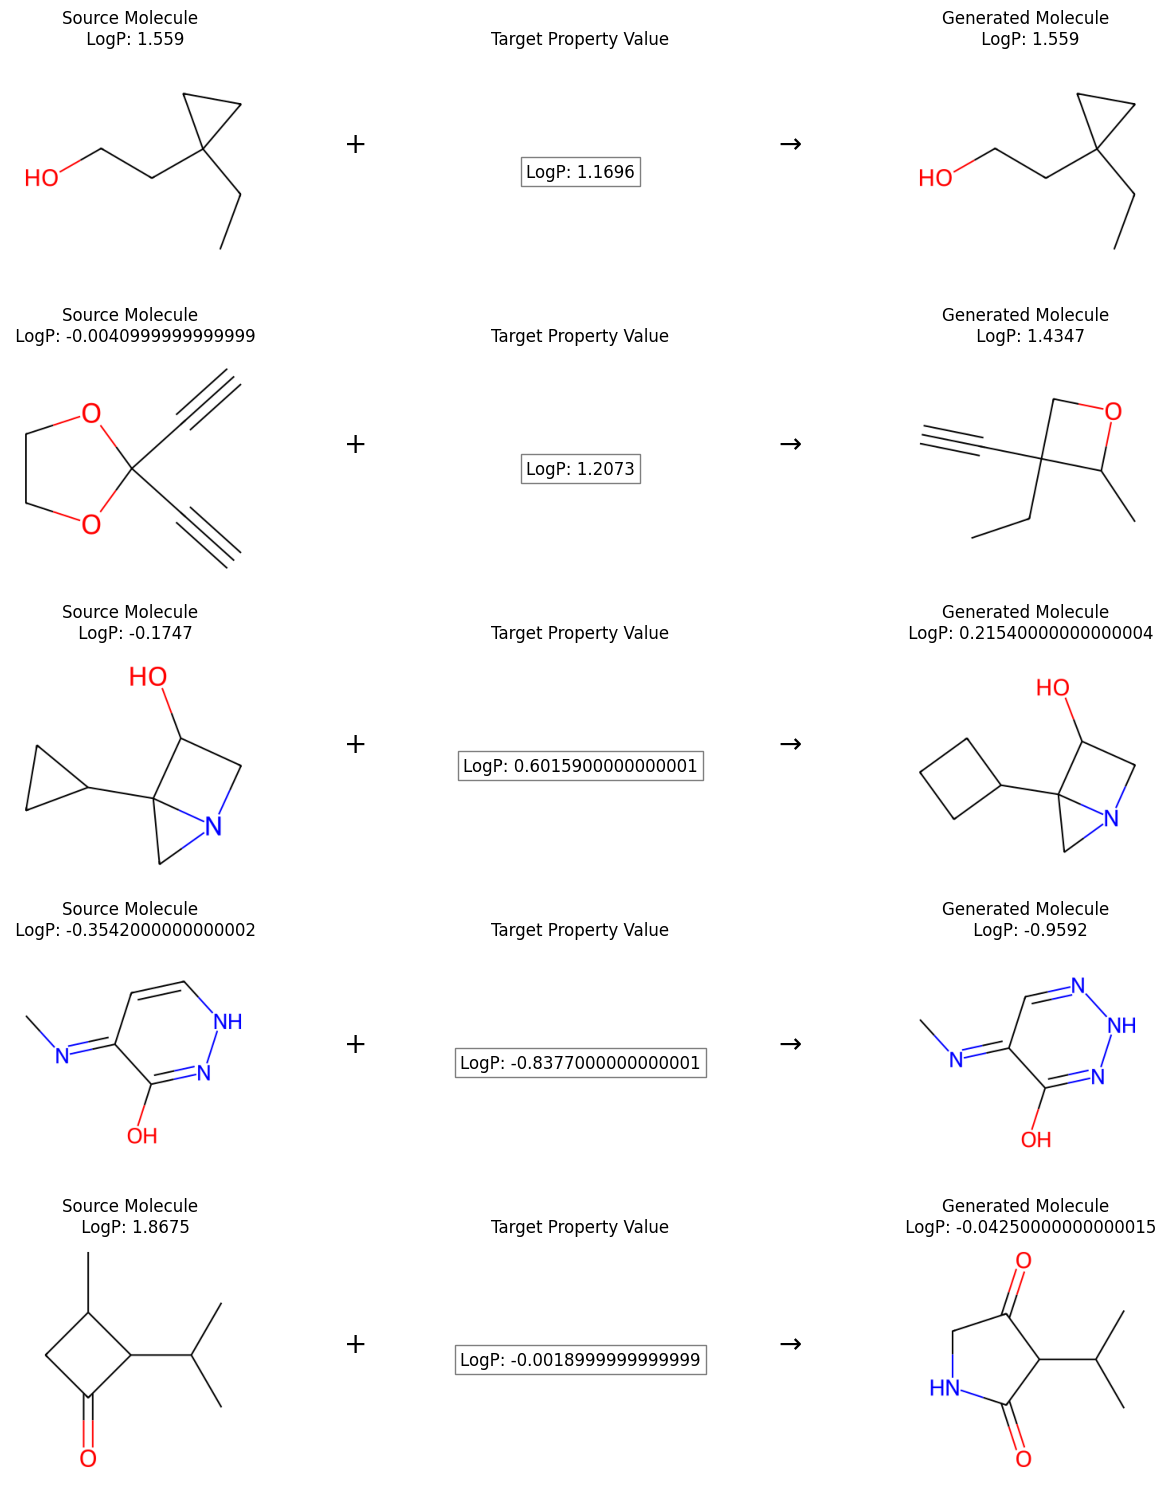

In [101]:
n_to_plot = 5
offset = 0

plot_style_transfer_2(
    og_smiles = source_smiles[offset:offset+n_to_plot],
    og_props = source_props[offset:offset+n_to_plot],
    random_props = target_props[offset:offset+n_to_plot],
    st_smiles = generated_smiles_cvae_tf[offset:offset+n_to_plot],
    st_props = generated_props_cvae_tf[offset:offset+n_to_plot])

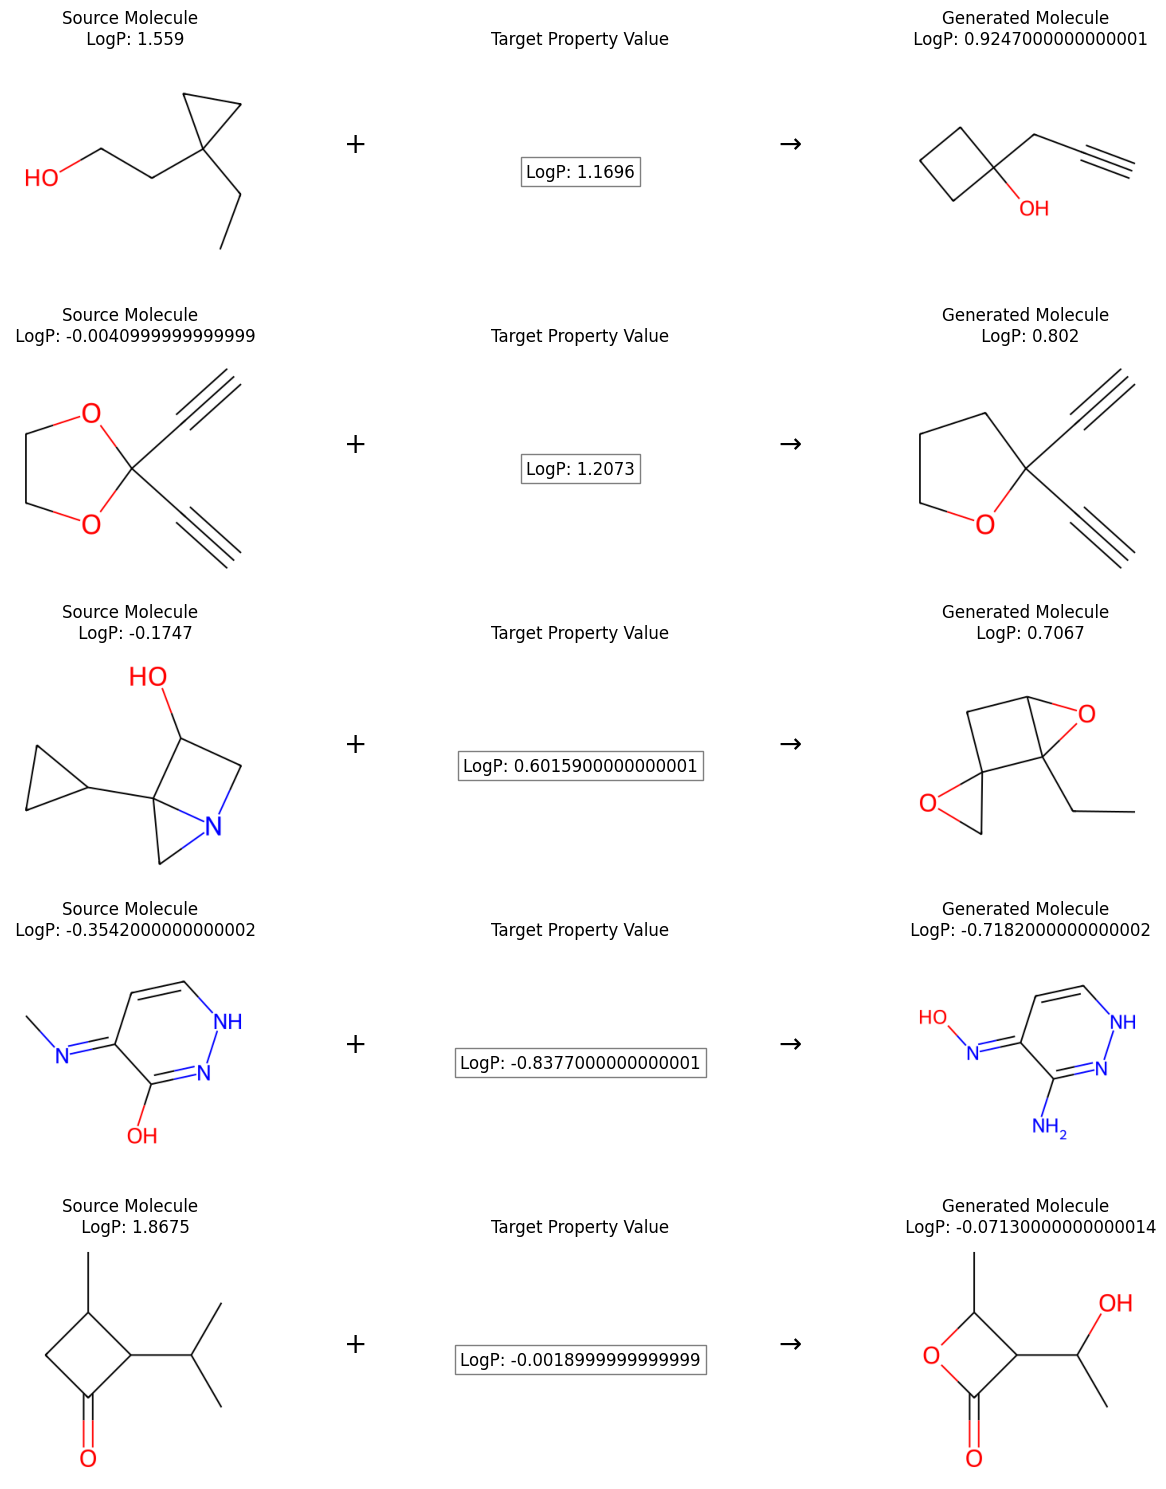

In [100]:
n_to_plot = 5
offset = 0

plot_style_transfer_2(
    og_smiles = source_smiles[offset:offset+n_to_plot],
    og_props = source_props[offset:offset+n_to_plot],
    random_props = target_props[offset:offset+n_to_plot],
    st_smiles = generated_smiles_kld[offset:offset+n_to_plot],
    st_props = generated_props_kld[offset:offset+n_to_plot])


In [184]:
inds = [i for i in range(len(generated_smiles_kld)) if  generated_props_cvae_tf[i] is not None and generated_props_kld[i] is not None and source_smiles[i] == generated_smiles_cvae_tf[i] and source_smiles[i] != generated_smiles_kld[i]]

print(inds)

[2, 36, 49, 66, 90, 113, 143, 177, 183, 188, 246, 269, 283, 285, 296, 299, 344, 350, 368, 380, 383, 412, 458, 461, 464, 471, 474, 490, 495, 509, 529, 542, 548, 552, 578, 581, 586, 596, 600, 609, 670, 673, 677, 696, 710, 716, 720, 763, 775, 803, 831, 832, 864, 870, 911, 924, 936, 939, 952, 983, 999, 1004, 1006, 1011, 1046, 1066, 1094, 1105, 1120, 1126, 1135, 1144, 1152, 1170, 1174, 1188, 1203, 1252, 1255, 1260, 1265, 1276, 1294, 1308, 1323, 1326, 1360, 1381, 1397, 1436, 1454, 1456, 1460, 1489, 1495, 1504, 1508, 1550, 1561, 1563, 1629, 1638, 1671, 1685, 1699, 1714, 1723, 1725, 1729, 1743, 1764, 1807, 1813, 1840, 1862, 1909, 1913, 2014, 2031, 2048, 2060, 2122, 2125, 2138, 2147, 2151, 2166, 2192, 2196, 2199, 2203, 2205, 2251, 2260, 2298, 2306, 2321, 2323, 2330, 2369, 2403, 2420, 2460]


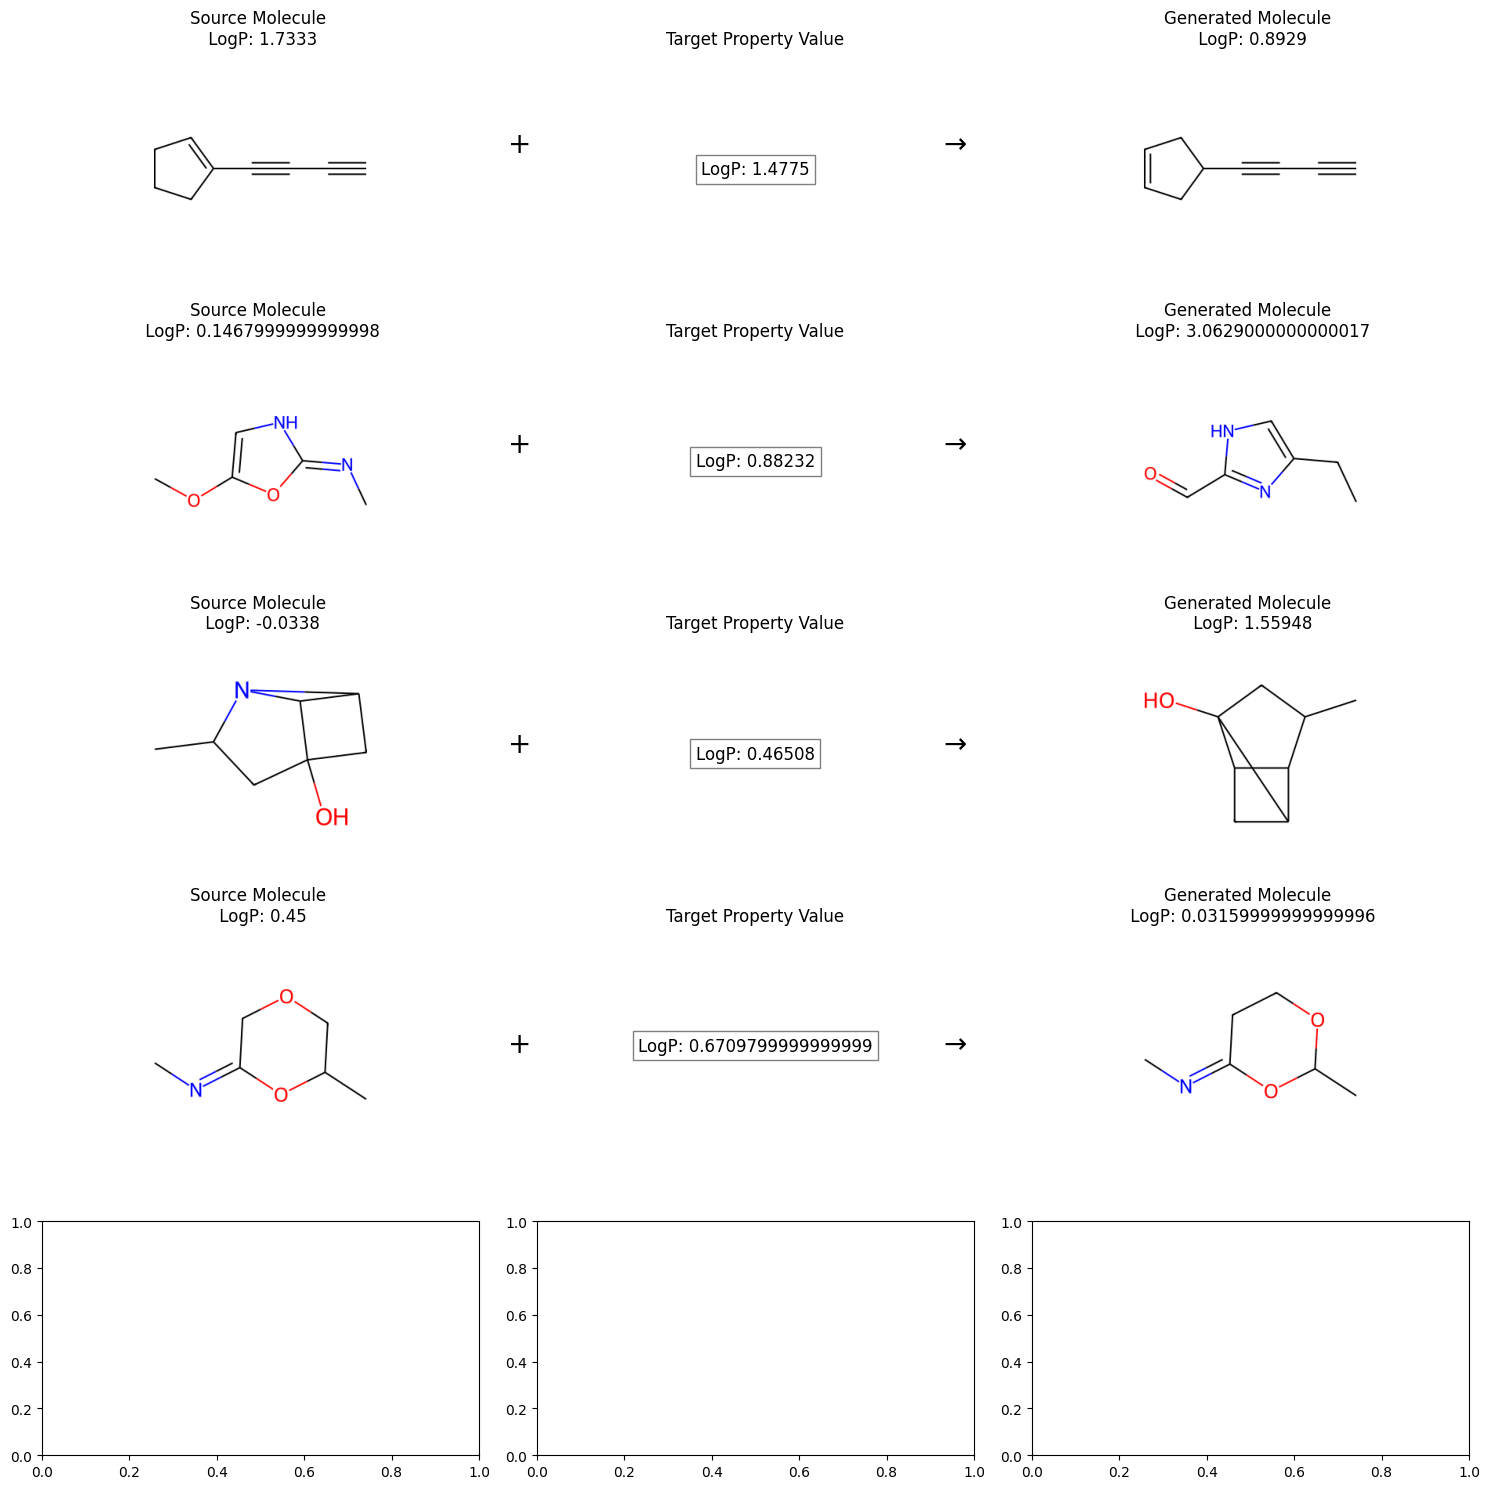

In [193]:
# inds[0:5]
# Good indices 51, 30, 10, 11, 15

i1 = 368
i2 = 36
i3 = 49
i4 = 66
i5 = 188

good_og_source = [source_smiles[i1], source_smiles[i2], source_smiles[i3], source_smiles[i4], source_smiles[i5]]
good_og_props =  [source_props[i1], source_props[i2], source_props[i3], source_props[i4], source_props[i5]]
good_target = [target_props[i1], target_props[i2], target_props[i3], target_props[i4], target_props[i5]]
good_st_smiles = [generated_smiles_kld[i1], generated_smiles_kld[i2], generated_smiles_kld[i3], generated_smiles_kld[i4], generated_smiles_kld[i5]]
good_st_props = [generated_props_kld[i1], generated_props_kld[i2], generated_props_kld[i3], generated_props_kld[i4], generated_props_kld[i5]]


plot_style_transfer_2(
    og_smiles = good_og_source,
    og_props = good_og_props,
    random_props = good_target,
    st_smiles = good_st_smiles,
    st_props = good_st_props)

## LSTM EVALUATION

In [4]:
# ONE SHOT LSTM

from rnn_sampler import ConditionalSmilesRnnSampler
from rnn_one_shot_model import ConditionalSmilesRnn as OneShotLSTM

lstm_definit = './models/EXPERIMENTS/ONE-SHOT-LSTM/UNCOND-DIST/LSTM_154_5.113.json'
lstm_params = './models/EXPERIMENTS/ONE-SHOT-LSTM/UNCOND-DIST/LSTM_154_5.113.pt'

lstm_sampler = ConditionalSmilesRnnSampler(device='cpu', batch_size = 128)
lstm_model = load_model(OneShotLSTM, lstm_definit, lstm_params, 'cpu', True)

In [5]:
n_samp = 300

new_hidden = lstm_model.init_hidden(n_samp, 'cpu')

actions = lstm_model.forward( x=None,
                    properties=target_props_normed, 
                    hidden = new_hidden, 
                    use_teacher_forcing = False, 
                    sampling = False,
                    return_actions = True, 
                    return_both = False, 
                    seq_len = 38)

In [525]:
# Load SD-LSTM Model
# lstm_params = 'models/LONG_RUNS/ZINC/LSTM/LSTM_final_0.769.pt'
# lstm_definit = 'models/LONG_RUNS/ZINC/LSTM/LSTM_final_0.769.json'

# lstm_definit = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_3_1.216.json'
# lstm_params = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_3_1.216.pt'

# lstm_definit = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_7_1.224.json'
# lstm_params = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_7_1.224.pt'

# lstm_definit = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_22_1.158.json'
# lstm_params = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_22_1.158.pt'

# lstm_definit = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_82_1.141.json'
# lstm_params = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_82_1.141.pt'

# lstm_definit = 'models/LSTM_QM9/batch_size_64_2/LSTM_20_1.190.json'
# lstm_params = 'models/LSTM_QM9/batch_size_64_2/LSTM_20_1.190.pt'

# lstm_definit = '../my_code_upload_old_params/models/LSTM_QM9/batch_size_64_2/LSTM_10_1.211.pt'
# lstm_params = '../my_code_upload_old_params/models/LSTM_QM9/batch_size_64_2'

# lstm_params = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM_2_0.007.pt'
# lstm_definit = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM_2_0.007.json'

# lstm_params = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_5_0.005.pt'
# lstm_definit ='../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_5_0.005.json'
# lstm_params = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_1_0.032.pt'
# lstm_definit = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_1_0.032.json'

# lstm_params = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM_1_0.541.pt'
# lstm_definit = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM_1_0.541.json'

# lstm_params = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_9_0.005.pt'
# lstm_definit = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_9_0.005.json'

# lstm_params = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_11_0.005.pt'
# lstm_definit = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_11_0.005.json'

# lstm_params = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_17_0.005.pt'
# lstm_definit = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_17_0.005.json'

# lstm_params = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_6_0.499.pt'
# lstm_definit = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_6_0.499.json'

# lstm_params = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_9_0.486.pt'
# lstm_definit = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_9_0.486.json'

# lstm_params = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_11_0.479.pt'
# lstm_definit = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/LSTM_11_0.479.json'

# lstm_params = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/model_6_66.302.pt'
# lstm_definit = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/model_6_66.302.json'

# lstm_params = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/model_final_73.302.pt'
# lstm_definit = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/model_final_73.302.json'

# lstm_params = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/model_200_66.762.pt'
# model_definit = '../my_code/models/NEW_LONG_RUNS/ZINC120/LSTM/model_200_66.762.json'

# lstm_params = './ACTION_SAMPLING_VANILLA_VAE/reg_models/LSTM_12_1.180.pt'
# lstm_definit = './ACTION_SAMPLING_VANILLA_VAE/reg_models/LSTM_12_1.180.json'

# lstm_definit = './models/EXPERIMENTS/LSTM_ZINC_DP_120/LSTM_32_0.462.json'
# lstm_params = './models/EXPERIMENTS/LSTM_ZINC_DP_120/LSTM_32_0.462.pt'

# lstm_definit = './models/EXPERIMENTS/LSTM_ZINC_DP_120_HS1024/LSTM_20_0.459.json'
# lstm_params = './models/EXPERIMENTS/LSTM_ZINC_DP_120_HS1024/LSTM_20_0.459.pt'

lstm_definit = './VANILLA_VAE/reg_models/LSTM_20_1.190.json'
lstm_params = './VANILLA_VAE/reg_models/LSTM_20_1.190.pt'

# lstm_definit = './VANILLA_VAE/reg_models/LSTM_20_1.190.json'
# lstm_params = './VANILLA_VAE/reg_models/LSTM_20_1.190.pt'

from rnn_sampler import ConditionalSmilesRnnSampler

# lstm_sampler = FastSampler(device = 'cpu', batch_size=64)
lstm_sampler = ConditionalSmilesRnnSampler(device='cpu', batch_size = 128)
lstm_model = load_rnn_model(
            model_definition= lstm_definit,
            model_weights = lstm_params,
            device = 'cpu',
            )

In [527]:
lstm_sampler.sample(model = lstm_model, properties= [ [a] for a in test_props[:10]] , num_to_sample=10)

['O=COCCC1CC1',
 'C#CC1(CO)CN=CO1',
 'CNc1cncnc1',
 'COC1CC2(CC2)C1',
 'Cc1oc(=N)n2c1CC2',
 'N=c1onc2n1C1CC21',
 'Cc1cnn(C)c1OC',
 'N#Cc1cc(C=O)c[nH]1',
 'CC(O)CN1CC1C',
 '[NH3+]C1CC(O)(C(=O)[O-])C1']

In [331]:
## ZINC
dataset_path = "data/ZINC250K/ZINC120/"
qmds = pd.read_csv(os.path.join(dataset_path, 'ZINC_clean.csv'))
print(qmds.columns)
props = list(qmds.drop(['ZINC_ID', 'SMILES'], axis=1).columns)
print(f'Properties in dataset: {props}')

# Seperate Test Train and Validation Datasets
indecies = np.load('data/ZINC250K/data_splits.npy')

train_smiles = np.array(qmds['SMILES'])[indecies == 0]
val_smiles = np.array(qmds['SMILES'])[indecies == 1]
test_smiles = np.array(qmds['SMILES'])[indecies == 2]

test_props = [ float(a) for a in pd.read_csv('data/ZINC250K/ZINC120/ZINC_clean.csv')['LogP'][indecies == 2]]
train_props = [ float(a) for a in pd.read_csv('data/ZINC250K/ZINC120/ZINC_clean.csv')['LogP'][indecies == 0]]
valid_props = [ float(a) for a in pd.read_csv('data/ZINC250K/ZINC120/ZINC_clean.csv')['LogP'][indecies == 1]]

Index(['ZINC_ID', 'SMILES', 'LogP'], dtype='object')
Properties in dataset: ['LogP']


In [528]:
## QM9
dataset_path = "data/QM9/"
qmds = pd.read_csv(os.path.join(dataset_path, 'QM9_clean.csv'))
print(qmds.columns)
props = list(qmds.drop(['QM9_id', 'SMILES'], axis=1).columns)
print(f'Properties in dataset: {props}')

# Seperate Test Train and Validation Datasets
indecies = np.load('data/QM9/data_splits.npy')

train_smiles = np.array(qmds['SMILES'])[indecies == 0]
val_smiles = np.array(qmds['SMILES'])[indecies == 1]
test_smiles = np.array(qmds['SMILES'])[indecies == 2]

test_props = [ float(a) for a in pd.read_csv('data/QM9/QM9_clean.csv')['LogP'][indecies == 2]]
train_props = [ float(a) for a in pd.read_csv('data/QM9/QM9_clean.csv')['LogP'][indecies == 0]]
valid_props = [ float(a) for a in pd.read_csv('data/QM9/QM9_clean.csv')['LogP'][indecies == 1]]

Index(['QM9_id', 'SMILES', 'LogP'], dtype='object')
Properties in dataset: ['LogP']


In [515]:
from tqdm import tqdm
from joblib import Parallel, delayed


def pairwise_distance(properties, i, j):
    return np.abs(properties[i] - properties[j])

def average_distance_with_tqdm_parallel(properties, n_jobs=-1):
    properties = np.array(properties)
    num_properties = len(properties)
    
    if num_properties < 2:
        return 0.0

    # Create a list of index pairs for which distances need to be calculated
    index_pairs = [(i, j) for i in range(num_properties) for j in range(i + 1, num_properties)]

    # Use joblib to calculate distances in parallel
    distances = Parallel(n_jobs=n_jobs)(
        delayed(pairwise_distance)(properties, i, j) for i, j in tqdm(index_pairs)
    )
    
    average_distance = np.mean(distances)
    
    return average_distance


average_distance_with_tqdm_parallel(test_props)

  1%|▏         | 685765/49995000 [00:15<09:19, 88133.42it/s] 

KeyboardInterrupt: 

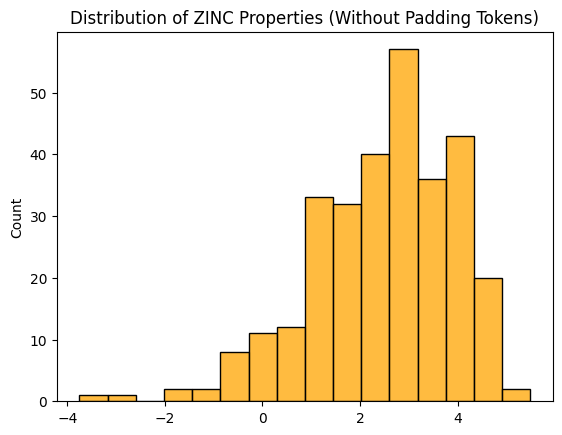

In [306]:
sns.histplot(target_props,  kde=False, color='orange')
plt.title('Distribution of ZINC Properties (Without Padding Tokens)')
plt.show()

### Baseline for Property Distance


In [529]:
def compute_metrics_lstm(lstm_sampler, lstm_model, target_props, train_smiles, seq_len = 120):
    # Sample smiles from property scores

    # raise Exception('Check Normalization')
    sample_smiles = lstm_sampler.sample(model=lstm_model, properties=target_props.clone(), num_to_sample=len(target_props), max_seq_len=seq_len)
    assert len(sample_smiles) == len(target_props)
    n_decodes = 0
    n_valid = 0
    n_valid_in_train = 0
    unique_valid = set()
    total_me = 0.0
    train_set = set(train_smiles)

    for i in range(len(sample_smiles)):
        n_decodes += 1
        smi = sample_smiles[i]
        prop = target_props[i]

        mol = Chem.MolFromSmiles(smi)

        if mol is not None:
            n_valid += 1
            can_smi = Chem.MolToSmiles(mol, canonical=True)
            unique_valid.add(can_smi)
            
            total_me += abs( pc(mol)[0] - prop)
                          
            # Check if in train set
            if can_smi in train_set:
                n_valid_in_train += 1

    validity = n_valid / n_decodes
    uniqueness = len(unique_valid) / n_valid
    novelty = (n_valid - n_valid_in_train) / n_valid
    mae = total_me / n_valid


    return validity, uniqueness, novelty, mae

In [531]:
target_props = random.choices(test_props, k=300)

all_y = np.concatenate((test_props, valid_props), axis=0)
mean = np.mean(all_y, axis = 0)
print(f'Normalizing Mean: {mean}')
std = np.std(all_y, axis = 0)
print(f'Normalizing STD: {std}')
# np.save(data_path + '/normalizer.py', [mean, std])
target_props_normed = (target_props - mean) / std
target_props_normed = torch.tensor([[a] for a in target_props_normed], dtype= torch.float32)

Normalizing Mean: 0.29867047750000003
Normalizing STD: 0.9960265062292806


In [532]:
sampled_smiles = lstm_sampler.sample(model=lstm_model, properties=target_props_normed, num_to_sample=len(target_props), max_seq_len=120)
# sampled_smiles = lstm_sampler.sample(model=lstm_model, properties= torch.tensor([[a] for a in target_props]), num_to_sample=len(target_props), max_seq_len=120)

# sampled_smiles

/home/chrome/Code/MolGen/my_code/LSTM_TF/action_sampler.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(actions)


In [533]:
generated_mols = [ Chem.MolFromSmiles(a) for a in sampled_smiles]
generated_props = [ None if a is None else pc(a)[0] for a in generated_mols]

generated_props[:10]

[1.5772,
 0.048279999999999934,
 -0.25784999999999986,
 -0.32243,
 -0.31302,
 1.7235,
 0.58917,
 0.12230000000000002,
 -1.0061200000000003,
 -0.8731000000000004]

In [534]:
# [float(a[0]) for a in target_props_normed]
np.mean([np.abs(target_props[i] - generated_props[i]) for i in range(len(generated_props)) if generated_props[i] is not None])
# generated_props

0.07730722972972975

In [535]:
target_props[:10]


[1.6037,
 0.0728999999999999,
 -0.3032000000000001,
 -0.3684000000000002,
 -0.2017999999999999,
 1.7399,
 0.5678,
 0.0202999999999999,
 -0.9576000000000002,
 -0.8394300000000001]

AttributeError: 'Tensor' object has no attribute 'armgax'

In [37]:
compute_metrics_lstm(lstm_sampler, lstm_model, train_smiles=train_smiles, target_props=target_props_normed) # Props still has error, use other code!!!

/home/chrome/Code/MolGen/my_code/LSTM_TF/action_sampler.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(actions)


ZeroDivisionError: division by zero

Conservative:

| Model | Val | Novely| Uniq | MSE |
|----|---|---|---|---|
| LSTM-9 | 1.0 | 0.1 | 1.0 | 6.2795|
| LSTM-11 | 1.0 | 0.14 | 1.0 | 5.9904 |
| LSTM-15 | 1.0 | 0.11|  1.0 | 6.24 |

Model:

| Model | Val | Novely| Uniq | MSE |
|----|---|---|---|---|
| LSTM-9 | | | | 6.3 |


Original CondGen Code:

| Model | Val | Novely| Uniq | MSE | MAE |
|----|---|---|---|---|---|
| LSTM-73 | 1 | | | 6.1 | |
| LSTM-200 | 0.96 | 1.0 | 0.97 | 6.1 | 2.4752 |

In [340]:
def average_distance(array):
    n = len(array)
    if n < 2:
        return 0  # No pairs exist if array has fewer than 2 elements

    # Calculate pairwise distances
    total_distance = 0
    num_pairs = 0

    for i in range(n):
        for j in range(i + 1, n):
            distance = abs(array[i] - array[j])
            total_distance += distance
            num_pairs += 1

    # Calculate the average distance
    average_distance = total_distance / num_pairs
    return average_distance

average_distance(test_props)

1.5986847089984746

## Property Error Baseline

In [ ]:
def mean_absolute_error(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")
    
    mse = sum(abs(a - b)  for a, b in zip(list1, list2)) / len(list1)
    return mse

In [ ]:
propsA = test_props
propsB = random.sample(test_props, len(test_props))

mse = mean_absolute_error(propsA, propsB)
print(f'Baseline MAE is: {mse}')

Baseline MAE is: 1.600169258


In [ ]:
mean = np.mean(test_props) 
propsMean = [mean for _ in range(len(test_props))]

mse = mean_absolute_error(propsMean, propsA)
print(f'Baseline MAE is: {mse}')

Baseline MAE is: 1.1380362280613991
